# Estudio de la demanda y precios de de la electricidad (2017-2019)

###                                                                                                                              <center>*Javier Solís García*</center>

## Índice:

 1. **Introducción.** 
 2. **Preparación para afrontar el problema.**
  1. **Obtención de datos.**
  2. **Definición de funciones para su uso posterior.**
 3. **Aplicación de procesos de clustering sobre los datasests.**
  1. **Exploración de datos de la demanda.**
  2. **Proceso de clustering sobre la demanda.**
  3. **Caracterizar los clusters obtenidos de la demanda.**
  4. **Exploración de datos de los precios.**
  5. **Proceso de clustering sobre los precios.**
  6. **Caracterizar los clusters obtenidos de los precios.**
 4. **Relacionar ambas series obtenidas.**
  1. **Análisis de la correlación entre demanda y precios.**
  2. **Búsqueda de reglas de asociación.**
 5. **Predicción de los precios de septiembre de 2019 con horizonte de 24 horas.**
  1. **Preparación de los datos.**
  2. **Definición y entrenamiento de la red neuronal.**
  3. **Predicción y evaluación de la red neuronal.**
 6. **Conclusiones.**
 7. **Posibles mejoras.**
 8. **Bibliografía.**
 
 
 
 
 ## 1.- Introducción:
 
El problema que vamos a realizar consiste en hacer un estudio sobre las series temporales de la demanda y el precio de la luz durante los años 2017, 2018 y 2019, para posteriormente intentar predecir el precio de la luz, a partir de la demanda con 24 horas de antelación.

Los datos necesarios serán extraidos de la <a href = 'https://www.ree.es/es/apidatos'>web de la REE</a>, y una vez obtenidos, le aplicaremos un proceso de clustering a los dos dataset, para posteriormente intentar caracterizar ambos datasets, con el fin de identificar cada cluster.

Una vez realizado todo el procedimiento anterior, intentaremos relacionar ambas series para responder preguntas como:

<ul>
<li> ¿Existe relación entre precio y demanda?</li>
<br>
<li> ¿Cambia esta relación por alguna circunstancia como las citadas antes: día de la semana, mes o estación, festividad ...?</li>
</ul>

Con estas respuestas, intentaremos hacer una predicción diaria, de los precios de las próximas 24 horas de septiembre de 2019. 
 
 
 
 ## 2.- Preparación para afrontar el problema:
 ### 2.A.- Obtención de los datos:
 
Al estar obteniendo datos de una API, el proceso de recolección de datos no ha sido tan simple como la lectura de un archivo CSV. Los datos de los recibiremos en formato JSON, el cual trae muchos datos que no necesitaremos para el estudio que nos atañe en esta ocasión. Por ello me he visto obligado a relizar un proceso de limpieza y procesamiento de los datos recibidos en formato JSON, para poder convertirlos en un DataFrame de pandas.

Pese a que podría haber procesado los datos de la misma forma la cual aprendí el año pasado, en la signatura de Arquitectura e Integración de Sistemas de Software, en esta ocasión he preferido realizar este procesamiento intentando usar la libreria de Pandas.

Por ello, he tenido que realizar dos funciones, una para la demanda y otra para los precios, que se encarguen de recibir un archivo en formato JSON y los conviertan en DataFrames. Además estas funciones también se encargan de hacer que la información en periodos de una hora, y no cada diez minutos que es como vienen inicialmente.




***Función que convierte los datos de la demanda del formato JSON a un DataFrame:***


In [1]:
def descarga_datos_demanda(uri):
    
    import pandas as pd
    import json
    import requests
    from  datetime import datetime
    
    #Carga de datos:
    get_json = requests.get(uri, timeout=1000)
    json1 = json.loads(get_json.text)
    included = pd.DataFrame(json1['included'])
    atributes = included['attributes']
    demanda_real = atributes[0]
    
    #Construcción del dataframe:
    values = pd.DataFrame(demanda_real['values'])
    
    #Filtrado y obtención de columnas:
    values[['date', 'time']] = values['datetime'].str.split('T',expand=True)
    del values['datetime']
    values[['hour','utc']] = values['time'].str.split('.',expand=True)
    del values['time']
    del values['utc']
    values[['h','m','s']] = values['hour'].str.split(':',expand=True)
    del values['s']
    del values['m']
    del values['hour']
    
    #Contrucción de dataframe con los valores por horas:
    val_hour = pd.DataFrame(values.groupby(['date','h']).value.sum())
    val_hour = val_hour.reset_index(level=[0,1])
    del val_hour['h']
    
    #Contrucción del dataframe objetivo:
    objective = pd.DataFrame((val_hour.groupby('date').value).apply(list))
    col=[]
    for i in range(0,24):
        col.append(str(i))
    
    #Construcción del dataframe resultado:
    res = pd.DataFrame(objective.value.tolist(),columns=col,index=objective.index)
    return res

***Función que convierte los datos de los precios del formato JSON a un DataFrame:***

In [2]:
def descarga_datos_precios(uri):
    
    import pandas as pd
    import json
    import requests
    from  datetime import datetime
    
    #Carga de datos:
    get_json = requests.get(uri, timeout=1000)
    json1 = json.loads(get_json.text)
    included = pd.DataFrame(json1['included'])
    atributes = included['attributes']
    precios_real = atributes[0]
    
    #Construcción del dataframe:
    values = pd.DataFrame(precios_real['values'])
    
    #Filtrado y obtención de columnas:
    values[['date', 'time']] = values['datetime'].str.split('T',expand=True)
    del values['datetime']
    values[['hour','utc']] = values['time'].str.split('.',expand=True)
    del values['time']
    del values['utc']
    values[['h','m','s']] = values['hour'].str.split(':',expand=True)
    del values['s']
    del values['m']
    del values['hour']
    
    #Contrucción de dataframe con los valores por horas:
    val_hour = pd.DataFrame(values.groupby(['date','h']).value.sum())
    val_hour = val_hour.reset_index(level=[0,1])
    del val_hour['h']
    
    #Contrucción del dataframe objetivo:
    objective = pd.DataFrame((val_hour.groupby('date').value).apply(list))
    col=[]
    for i in range(0,24):
        col.append(str(i))
    
    #Construcción del dataframe resultado:
    res = pd.DataFrame(objective.value.tolist(),columns=col,index=objective.index)
    return res

La API que estamos utilizando solo permite bajarse un máximo de 744 datos, lo cual es equivalente a los datos de un mes. Como nosotros necesitamos obtener la información de 36 meses, he realizado otras dos funciones, que se encargarán de pedir los datos que necesitamos a la API. Por cada petición realizada, las funciones llamarán internamente a las funciones creadas anteriormente para ir procesando los datos poco a poco. Ádemas irán concatenando los DataFrames obtenidos por cada petición, de forma que al finalizar las funciónes devolverán los datasets listos para empezar a trabajar con ellos.


***Función que obtiene el dataset de la demanda:***

In [3]:
def get_dataset_demanda():
    res = None
    meses30 = [4,6,9,11]
    url1 = 'https://apidatos.ree.es/es/datos/demanda/demanda-tiempo-real?start_date='
    url2 = '-01T00:00&end_date='
    url3 = 'T23:50&time_trunc=hour'
    
    #Repetir el bucle por cada mes de cada año:
    for year in range(2017,2020):
        for month in range(1,13):
            
            #Definición cantidad de días de cada mes:
            days = 31
            
            if month in meses30:
                days = 30
            elif month == 2:
                days=28
                
                
            #Construcción de uris:    
            if month<10:
                uri = url1+str(year)+'-0'+str(month)+url2+str(year)+'-0'+str(month)+'-'+str(days)+url3
            else:
                uri = url1+str(year)+'-'+str(month)+url2+str(year)+'-'+str(month)+'-'+str(days)+url3
            
            print('Obteniendo datos de demanda de = '+str(month)+'/'+str(year))
            
            #print(uri)
            #Obtención de datos
            if year == 2017 and month == 1:
                res = descarga_datos_precios(uri)
            else:
                res = pd.concat([res, descarga_datos_precios(uri)])
    return res

***Función que obtiene el dataset de los precios:***

In [4]:
def get_dataset_precios():
    res = None
    meses30 = [4,6,9,11]
    url1 = 'https://apidatos.ree.es/es/datos/mercados/precios-mercados-tiempo-real?start_date='
    url2 = '-01T00:00&end_date='
    url3 = 'T23:50&time_trunc=hour'
    
    #Repetir el bucle por cada mes de cada año:
    for year in range(2017,2020):
        for month in range(1,13):
            
            #Definición cantidad de días de cada mes:
            days = 31
            
            if month in meses30:
                days = 30
            elif month == 2:
                days=28
                
                
            #Construcción de uris:    
            if month<10:
                uri = url1+str(year)+'-0'+str(month)+url2+str(year)+'-0'+str(month)+'-'+str(days)+url3
            else:
                uri = url1+str(year)+'-'+str(month)+url2+str(year)+'-'+str(month)+'-'+str(days)+url3
            
            print('Obteniendo datos de precios de = '+str(month)+'/'+str(year))
            
            
            #Obtención de datos
            if year == 2017 and month == 1:
                res = descarga_datos_precios(uri)
            else:
                res = pd.concat([res, descarga_datos_precios(uri)])
    return res

La manera de invocar a estas funciones y obtener los datos sería la siguiente:

In [5]:
#demanda = get_dataset_demanda()
#demanda.to_csv('demanda.csv')

#precios = get_dataset_precios()
#precios.to_csv('precios.csv')

Como para obtener los dos datasets vamos a tener que realizar un total de 72 peticiones, para agilizar el proceso, y no ralentizar tanto el proceso de ejecución de este kernel, he precargado ya los dos datasets obtenidos de ejecutar las anteriores funciones en los siguientes archivos:
>demanda.csv 

>precios.csv

Por lo que vamos a proceder a cargar y mostrar los datasets obtenidos:

In [6]:
import pandas as pd
demanda = pd.read_csv('demanda.csv')
precios = pd.read_csv('precios.csv')
print('numero de datos del DataFrame de la demanda =', demanda.shape)
print('numero de datos del DataFrame de los precios =', precios.shape)

numero de datos del DataFrame de la demanda = (1095, 25)
numero de datos del DataFrame de los precios = (1095, 25)


Como podemos ver ambos DataFrame tienen el mismo número de columnas y de filas, ya que ambas recogen datos de los mismos dias.

### 2.B.- Definición de funciones para su uso posterior:

Para el desarrollo de este estudio he necesitado definir algunas funciones. Este apartado se dedicará a explicar y definir dichas funciones para poder acceder a ellas de aquí en adelante.

Las funciones son:

***Función 1: añade más información a los datasets***

In [7]:
###################################### Funciones a las que llamará define_dataset()#############################################

# Esta función definirá a qué año pertenece cada línea del dataset
def define_año(data):                                 
    res = []
    year=2016
    for i in range(0,len(data)):
        if(i%365==0):
            year+=1
        res.append(year)
    data['año'] = pd.Series(res)
    return data

# Esta función definirá para cada línea del dataset qué día de la semana es
def define_dias_semana(data):
    dias=[6,0,1,2,3,4,5] #2017 empezó en domingo
    res=[]
    for i in range(0,len(data)):
        res.append(dias[i%7])
    data['dia_semana'] = pd.Series(res)
    return data

# Esta función definirá a qué estación pertenece cada línea del dataset
def define_estaciones(data):
    inicioEstaciones = [78,170,264,355]
    # Inicio de =       P   V   O   I
    res=[]
    for i in range(0,len(data)):
        estacion=0
        if i>364:
            i = i % 365
        if i>=78 and i<170:
            estacion=1
        elif i>=170 and i<264:
            estacion=2
        elif i>=265 and i<355:
            estacion=3
        res.append(estacion)
    data['estacion'] = pd.Series(res)
    return data

# Esta función inicializará un índice de los días festivos de cada año
def indices_festivos():
    fest17 = [0,5,32,56,77,98,99,100,101,102,103,104,105,106,120,205,224,226,284,304,339,341,358]
    fest18 = [0,5,32,41,77,84,85,86,87,88,89,90,91,120,205,223,226,284,304,339,341,358]
    fest19 = [0,5,32,61,77,13,104,105,106,107,108,109,110,111,120,205,222,226,284,304,339,341,358]
    for i in range(0,len(fest18)):
        fest18[i] = fest18[i]+365
    for i in range(0,len(fest19)):
        fest19[i] = fest19[i]+(365*2)
    return fest17, fest18, fest19

# Esta función definirá para cada línea del dataset si se trataba de un día destivo o no
def define_festivos(data):
    res = []
    f17,f18,f19 = indices_festivos()
    for i in range(0,len(data)):
        festivo=0
        if (i in f17) or (i in f18) or (i in f19):
            festivo = 1
        res.append(festivo)
    data['festivo'] = pd.Series(res)
    return data

# Esta función inicializará un índice de los días previos a un día festivo de cada año
def indices_pre_festivos():
    f17,f18,f19 = indices_festivos()
    pf17=[]
    pf18=[]
    pf19=[]
    for i in range(1,len(f17)):
        pf17.append(f17[i]-1)
        
    for i in range(1,len(f18)):
        pf18.append(f18[i]-1)
        
    for i in range(1,len(f19)):
        pf19.append(f19[i]-1)
    
    pf17.append(364)
    pf18.append(364 + 365)
    pf19.append(364 + 365*2)
    return pf17, pf18, pf19

# Esta función definirá por cada línea del dataset si se trataba de un día previo a un festivo
def define_pre_festivos(data):
    res=[]
    pf17,pf18,pf19 = indices_pre_festivos()
    for i in range(0,len(data)):
        pre_festivo = 0
        if (i in pf17) or (i in pf18) or (i in pf19):
            pre_festivo = 1
        res.append(pre_festivo)
    data['pre-festivo'] = pd.Series(res)
    return data

################# Función que se encargará de incorporar todos los datos anteriores a un dataset dado ##########################

def define_dataset(data):
    data = define_año(data)
    data = define_dias_semana(data)
    data = define_estaciones(data)
    data = define_festivos(data)
    data = define_pre_festivos(data)
    return data

***Función 2: elimina los valores faltantes del dataset***

Como solución al problema de los datos faltantes por el adelanto de horas, he elegido escoger el mismo valor que hubo exactamente una semana atrás.

In [8]:
def arregla_dias(data): 
    dias = data.loc[data['23'].isna(),:]
    for i in dias.index:
        print('demanda del día ',i,'(Hora, demanda) =',data.loc[i,['23']])
        print('demanda del día ',i-7,'(Hora, demanda) =',data.loc[i-7,['23']])
        data.loc[i,['23']] = data.loc[i - 7,['23']]
        print('demanda del día ',i,'(Hora, demanda) =',data.loc[i,['23']])
        print('==================================================================')
    return data

***Función 3: obtiene la media por horas de un grupo de días dado***

In [9]:
def mean_day(data):
    res = []
    days = data.index
    for i in days:
        res.append(data.loc[i,'0':'23'].mean())
    return pd.Series(res)

***Función 4: obtiene la medias según día de la semana, festivos, previos a festivos, días normales, por estaciones y por años***

In [10]:
def media_tipo_de_dia(data):
    valoresBar = []
    diasNormales = []
    fest = indices_festivos()
    prefest = indices_pre_festivos()
    
    for i in range(0,7):
        dias = mean_day(data.loc[data.dia_semana==i,:]).mean()
        valoresBar.append(dias)
    
    valoresBar.append(mean_day(data.loc[data.festivo==1,:]).mean())
    valoresBar.append(mean_day(data.loc[data['pre-festivo']==1,:]).mean())
    
    for i in range(0,len(data)):
        if  ( i not in fest) and ( i not in prefest) :
            diasNormales.append(i)
    valoresBar.append(mean_day(data.loc[diasNormales,:]).mean())

    for i in range(2017,2020):
        valoresBar.append(mean_day(data.loc[data.año==i,:]).mean())
        
    for i in range(0,4):
        valoresBar.append(mean_day(data_d.loc[data_d.estacion==i,:]).mean())
    return valoresBar

***Función 5: obtiene la medias por horas según día de la semana, festivos, previos a festivos, días normales, por estaciones y por años***

In [11]:
def media_horas(data):
    indicesFest = indices_festivos()
    indicesPreFest = indices_pre_festivos()
    normales = []
    
    for i in range(0,len(data)):
        if (i not in indicesFest) and (i not in indicesPreFest):
            normales.append(i)
            
    inv = data.loc[data.estacion==0,'0':'23'].mean()
    pri = data.loc[data.estacion==1,'0':'23'].mean()
    ver = data.loc[data.estacion==2,'0':'23'].mean()
    oto = data.loc[data.estacion==3,'0':'23'].mean()
    fest = data.loc[data.festivo==1,'0':'23'].mean()
    prefest = data.loc[data['pre-festivo']==1,'0':'23'].mean()
    normales = data.loc[normales,'0':'23'].mean()
    horas17 = data.loc[data.año==2017,'0':'23'].mean()
    horas18 = data.loc[data.año==2018,'0':'23'].mean()
    horas19 = data.loc[data.año==2019,'0':'23'].mean()
    
    return [inv,pri,ver,oto,fest,prefest,normales,horas17,horas18,horas19]

***Función 6: obtiene la variación de distancias y crecimiento de las distancias de un número de clusters dado***

In [12]:
def get_distancia_crecimiento(dendrograma,numero_cluster):
    distancias=[]
    crecimientos=[]
    datos = dendrograma[-numero_cluster:]
    datos_revert = datos[::-1]
    
    for i in range(0,len(datos_revert)):
        distancias.append(datos_revert[i][2])
    for i in range(0,len(datos_revert)-1):
        crecimientos.append(datos_revert[i][2]-datos_revert[i+1][2])
    return distancias, crecimientos

***Función 7: realiza un análisis de los espectros de un número de cluster K de un dataset***

In [13]:
def analiza_siluetas(data,K):
    
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    # Se asegura que el mínimo de cluster es 2, porque considero que no tiene sentido realizar un análisis de un cluster
    K+=1
    if K <3:
        print('*\Se ha establecido el número de K=2 porque no tiene sentido hacer un cluster\*\n')
        K=3
    
    # Realiza iteraciones para realizar un análisis que va desde 2 clusters hasta k clusters
    for k in range(2,K):
        
        # Inicializa modelo de KMeans con un número k de clusters
        modelKmeans = KMeans(k)
        
        # Entrenamos el modelo con el dataset dado
        modelKmeans.fit(data)
        
        # Obtenemos las etiquetas que se le han colocado a cada línea
        etiquetas = modelKmeans.labels_
        
        # Obtenemos la medía del valor de las siluetas del dataset para k clusters escogidos por el modelo
        silueta_mean = silhouette_score(data,etiquetas)
        
        # Obtenemos las siluetas del dataset para los k clusters escogidos por el modelo
        todas_siluetas = silhouette_samples(data,etiquetas)
        
        # Preparación de representación de las siluetas obtenidas
        plt.figure(figsize=(20,10))
        plt.title('Silueta para '+str(k)+' clusters')

        print('Para K igual a',k,'la media de la silueta es:',silueta_mean)
        
        # Mostramos las siluetas obtenidas
        y_min=10
        for i in range(0,k):
            
            # Obtener silueta para el cluster i
            silueta = todas_siluetas[etiquetas==i]
            silueta.sort()
            
            # Mostramos la silueta
            y_max = y_min + silueta.shape[0]
            plt.fill_betweenx(np.arange(y_min,y_max),0,silueta,alpha=0.7)
            plt.text(-0.01,y_min+0.5*silueta.shape[0],str(i+1))
            
            # Dejamos espacio para que no se pisen las siluetas entre sí
            y_min = y_max + 10
            print('Para el cluster',i,'la silueta vale:',silueta.mean())
        plt.show()
    

***Función 8: genera matrices de contención por año, por días de la semana, por estaciones, y por tipo de días***

In [14]:
################################## Funciones a las que llamará genera_matrices_contencion() ####################################

# Obtiene el porcentaje de los días, según el año, que está en cada cluster
def cantidad_por_year(cluster,data,year):
    cantidad=(len(cluster.loc[cluster.año==year,:])/len(data.loc[data.año==year,:]))*100
    return cantidad

# Genera la matriz de contención que muestra por filas los cluster y por columnas los años
def contencion_year(clusters,data):
    columnas=[2017,2018,2019]
    indices=[]
    res = pd.DataFrame()
    for i in range(0,len(clusters)):
        indices.append(str(i))
    indices.append('Total:')
    indice = pd.Series(indices)
    res['Cluster'] = indice
    
    for year in range(0,len(columnas)):
        total=0
        cantidades=[]
        for i in range(0,len(clusters)):
            cantidad=cantidad_por_year(clusters[i],data,columnas[year])
            cantidades.append(cantidad)
            total+=cantidad
        cantidades.append(total)
        res[columnas[year]]=cantidades
    res=res.set_index('Cluster')
    return res

# Obtiene el porcentaje de los días, según la estación a la que pertenecen, que está en cada cluster
def candidad_estacion_cluster(cluster,data,numero_cluster):
    res = []
    res.append(numero_cluster)
    for i in range(0,4):
        porcentaje = (len(cluster.loc[cluster.estacion==i,:])/len(data.loc[data.estacion==i,:]))*100
        res.append(porcentaje)
    return res
        
# Genera la matriz de contención que tiene por filas los clusters y por columnas las estaciones
def contencion_estaciones(clusters,data):
    for i in range(0,len(clusters)):
        fila = candidad_estacion_cluster(clusters[i],data,i)
        if i == 0:
            res = pd.DataFrame([fila], columns=['cluster','Invierno','Primavera','Verano', 'Otoño'])
        else:
            fila = pd.DataFrame([fila], columns=['cluster','Invierno','Primavera','Verano', 'Otoño'])
            res = pd.concat([res,fila])
    totales = ['Total:',res['Invierno'].sum(),res['Primavera'].sum(),
               res['Verano'].sum(),res['Otoño'].sum()]
    res = res.reset_index().drop('index',axis=1)
    res.loc[len(clusters),:] = totales
    res=res.set_index(['cluster'])
    return res

# Obtiene el porcentaje de los días, según el día de la semana, que está en cada cluster
def cantidad_por_dia(cluster,data,dia):
    cantidad=(len(cluster.loc[cluster['dia_semana']==dia,:])
              /len(data.loc[data['dia_semana']==dia,:]))*100
    return cantidad

# Genera la matriz de contención que tiene por filas los clusters y por columnas los días de la semana
def contencion_dia(clusters,data):
    columnas=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
    indices=[]
    res = pd.DataFrame()
    for i in range(0,len(clusters)):
        indices.append(str(i))
    indices.append('Total:')
    indice = pd.Series(indices)
    res['Cluster'] = indice
    for dia in range(0,7):
        total=0
        cantidades=[]
        for i in range(0,len(clusters)):
            cantidad=cantidad_por_dia(clusters[i],data,dia)
            cantidades.append(cantidad)
            total+=cantidad
        cantidades.append(total)
        res[columnas[dia]]=cantidades
    res=res.set_index('Cluster')
    return res


# Obtiene el porcentaje de los días festivos que hay en un cluster
def cantidad_festivos_cluster(cluster,data):
    cantidad = ((len(cluster.loc[cluster.festivo==1,:])/len(data.loc[data.festivo==1,:])))*100
    return cantidad

# Obtiene el porcentaje de los días festivos que hay en cada cluster
def cantidad_festivos(clusters,data):
    res=[]
    total=0
    for i in range(0,len(clusters)):
        cantidad = cantidad_festivos_cluster(clusters[i],data)
        res.append(cantidad)
        total+=cantidad
    res.append(total)
    res = pd.Series(res)
    return res

# Obtiene el porcentaje de los días previos a un día festivo que hay en un cluster
def cantidad_prefestivos_cluster(cluster,data):
    cantidad = ((len(cluster.loc[cluster['pre-festivo']==1,:])/len(data.loc[data['pre-festivo']==1,:])))*100
    return cantidad

# Obtiene el porcentaje de los días previos a un día festivo que hay en cada cluster
def cantidad_prefestivos(clusters,data):
    res=[]
    total=0
    for i in range(0,len(clusters)):
        cantidad = cantidad_prefestivos_cluster(clusters[i],data)
        res.append(cantidad)
        total+=cantidad
    res.append(total)
    res = pd.Series(res)
    return res

# Obtiene el porcentaje de los días que no son festivos ni previos a un festivo que hay en un cluster
def cantidad_normal_cluster(cluster,data):
    no_festivos = cluster.loc[cluster.festivo==0,:]
    data_no_festivos = data.loc[data.festivo==0,:]
    cantidad = ((len(no_festivos.loc[cluster['pre-festivo']==0,:])
                 /len(data_no_festivos.loc[data_no_festivos['pre-festivo']==0,:])))*100
    return cantidad

# Obtiene el porcentaje de los días que no son festivos ni previos a un festivo, que hay en cada cluster
def cantidad_normal(clusters,data):
    res=[]
    total=0
    for i in range(0,len(clusters)):
        cantidad = cantidad_normal_cluster(clusters[i],data)
        res.append(cantidad)
        total+=cantidad
    res.append(total)
    res = pd.Series(res)
    return res

# Genera la matriz de contención que tiene por fila el número de clusters, y por columnas: si son festivos, previos a un 
# festivo o si son días normales
def contencion_festivos(clusters,data):
    indices=[]
    for i in range(0,len(clusters)):
        indices.append(str(i))
    indices.append('Total:')
    indice = pd.Series(indices)
    res = pd.DataFrame()
    res['Cluster'] = indice
    res['Festivo'] = cantidad_festivos(clusters,data)
    res['Pre-festivo'] = cantidad_prefestivos(clusters,data)
    res['Normales'] = cantidad_normal(clusters,data)
    res = res.set_index('Cluster')
    return res


###### Función que se encargará de incorporar todos los datos anteriores para obtener todas las matrices de conteción ##########

def genera_matrices_contencion(clusters,data):
    year = contencion_year(clusters,data)
    season = contencion_estaciones(clusters,data)
    day = contencion_dia(clusters,data)
    type_day = contencion_festivos(clusters,data)
    return year,season,day,type_day

***Función 9: Conjunto de funciones que convierten en columnas los datos y permiten aplicarle retrasos y transformaciones matemáticas***

In [15]:
import math as math

#Función que convierte un DataFrame en una Serie
def convierte_en_serie_horas(data):
    res = []
    for i in range(0,len(data)):
        for j in range(0,24):
            res.append(data.loc[i,str(j)])
    return pd.Series(res)

#Función que convierte un DataFrame en una Serie, pero eleva los datos a un exponente dado
def convierte_en_serie_horas_exp(data,exp):
    res = []
    for i in range(0,len(data)):
        for j in range(0,24):
            res.append(data.loc[i,str(j)]**exp)
    return pd.Series(res)

#Función que convierte un DataFrame en una Serie pero con un retraso en los datos
def demanda_retrasada(data, retraso,exp=1):
    res = []
    for i in range(0, retraso):
        res.append(None)
        
    for i in range(0,len(data)):
        for j in range(0,24):
            res.append(data.loc[i,str(j)]**exp)
    if retraso != 0:        
        return pd.Series(res[:-retraso])
    else:
        return pd.Series(res[:])

#Función que convierte un DataFrame en una Serie con un retraso en los datos, además de aplicar una transformación logarítmica
def demanda_retrasada_log(data, retraso, base):
    res = []
    for i in range(0, retraso):
        res.append(None)
        
    for i in range(0,len(data)):
        for j in range(0,24):
            res.append(math.log(data.loc[i,str(j)],base))
            
    if retraso != 0:        
        return pd.Series(res[:-retraso])
    else:
        return pd.Series(res[:])

***Función 10: función que discretiza los valores de los precios en función de unos valores dados:***

In [16]:
def discretiza_precios(data, intervalos):
    i1 = intervalos[0]
    i2 = intervalos[1]
    i3 = intervalos[2]
    res = data
    for i in range(0,len(data)):
        for j in range(0,24):
            etiqueta = None
            valor = res.loc[i,str(j)]
            if valor < i1:
                etiqueta = 'precio bajo'
            elif valor > i3:
                etiqueta = 'precio alto'
            elif (valor >= i1) and (valor<=i2):
                etiqueta = 'precio medio-bajo'
            else:
                etiqueta = 'precio medio-alto'
    
            res.loc[i,str(j)] = etiqueta
    return res

***Función 11: función que discretiza los valores de la demanda en función de unos valores dados:***

In [17]:
def discretiza_demanda(data, intervalos):
    i1 = intervalos[0]
    i2 = intervalos[1]
    i3 = intervalos[2]
    res = data
    for i in range(0,len(data)):
        for j in range(0,24):
            etiqueta = None
            valor = res.loc[i,str(j)]
            if valor < i1:
                etiqueta = 'demanda baja'
            elif valor > i3:
                etiqueta = 'demanda alta'
            elif (valor >= i1) and (valor<=i2):
                etiqueta = 'demanda media-baja'
            else:
                etiqueta = 'demanda media-alta'
    
            res.loc[i,str(j)] = etiqueta
    return res

***Función 12: función que, con un retraso dado, crea una serie de la demanda retrasada y discretizada***

In [18]:
def demanda_retrasada_discretizada(data, retraso):
    res = []
    for i in range(0, retraso):
        res.append(None)
        
    for i in range(0,len(data)):
        for j in range(0,24):
            res.append(data.loc[i,str(j)]+'-'+str(retraso))
            
    return pd.Series(res[:-retraso])

***Función 13: función que aplica el algoritmo Apriori y muestra los resultados***

In [19]:
def apriori(datos, soporte, confianza):
    from apyori import apriori
    resultados = apriori(filas, min_support=soporte, min_confidence=confianza)
    resultados = list(resultados)
    for item in resultados:

        pair = item[0] 
        items = [x for x in pair]
        print("Regla: " + str(list(item.ordered_statistics[0].items_base))
              + " -> " + str(list(item.ordered_statistics[0].items_add)))
        print("Soporte: " + str(item[1]))
        print("Confianza: " + str(item[2][0][2]))
        print("=====================================")

***Función 14: función que calcula el número de días que son necesarios para obtener el número de horas que usaremos para la predicción***

In [20]:
def dias_para_prediccion(mirar_atras):
    dias = 1
    while mirar_atras>24:
        mirar_atras-=24
    dias+=1
    return dias

***Función 15: Convierte los datos en un array de forma que puedan ser aceptados por la red neuronal***

In [21]:
#Función que convierte una lista de listas de diferentes tamaños en una lista de elementos
def serializa_lista_distintos_tam(lista):  
    res = []
    for i in range(0, len(lista)):
        size = len(lista[i])
        for j in range(0,size):
            res.append(lista[i][j])
    return res

# Función que calcula el número de horas que se deben de escoger de un día, en el caso de que no se deba coger entero
def primeras_horas(mirar_atras):
    res = mirar_atras
    while res>24:
        res-=24
    res = str(24 - res)
    return res

# Función que crea una lista de las horas necesarias para realizar la predicción
def preparadatos_fila(datos, i ,necesarios, mirar_atras, horas):
    res = []
    for retroceso in range(0, necesarios):
        seleccionado = i - necesarios + retroceso
        
        if retroceso==0:
            fila = datos.loc[seleccionado,horas:'23']
            res.append(fila)
        else:
            fila =  datos.loc[seleccionado,'0':'23']
            res.append(fila)
            
    res = serializa_lista_distintos_tam(res)
    return res

                        
# Función que prepara los datos para ser utilizados por la red neuronal
def crea_base_datos(datos, mirar_atras):
    
    import numpy as np
    
    #En caso de que los datos traigan una indexiación superior a 1, reinicia este índice para poder operar con el
    datos = datos.reset_index()
    del datos['index']
    
    X = []
    y = []
    
    necesarios = dias_para_prediccion(mirar_atras)
    horas = primeras_horas(mirar_atras)

    for i in range(necesarios,len(datos)-1):
        fila = preparadatos_fila(datos, i ,necesarios, mirar_atras, horas)
        X.append(fila)
        y.append(datos.loc[i,'0':'23'])
  
    X = np.array(X)
    X = np.reshape(X, (X.shape[0],1,X.shape[1]))
    y = np.array(y)

    print('Días necesarios = '+str(necesarios),
        '\nHora a partir de la que se cogen datos del último día = '+horas,
        '\nTamaño X = ' + str(X.shape),
        '\nTamaño de y = ' + str(y.shape))
  
    return X, y

## 3.- Aplicación de procesos de clustering sobre los datasests
  ### 3.A.- Exploración de datos de la demanda:
  
En esta primera parte efectuaremos una exploración inicial de los datos de la demanda, para estudiar las columnas del dataset, y explorar tendencias en el dataset.

El dataset inicial que tenemos para hacer el estudio tiene el siguiente tamaño:

In [22]:
demanda.shape

(1095, 25)

A continuación procederemos a mostrar los 5 primeros datos del dataset, para tener una idea de como es:

In [23]:
demanda.head()

,date,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2017-01-01,146834,141117,132157,124264,118132,115424,115966,117857,117670,...,148568,141087,137795,140318,156288,165457,171563,175309,172195,159458.0
1,2017-01-02,143914,130578,122994,119329,118373,122091,134985,153716,169952,...,196514,191353,189032,192392,203517,207996,209675,208212,197361,180042.0
2,2017-01-03,163693,149531,139874,136777,135006,138748,151426,173025,192361,...,206627,200819,198672,201358,212371,215953,217262,214419,202046,184097.0
3,2017-01-04,167281,152964,144316,140374,139189,141540,153715,175226,192779,...,202160,196757,195004,197124,207352,211739,211690,211427,201631,184728.0
4,2017-01-05,168956,153819,145109,140653,139125,141012,151185,170638,186695,...,193182,185370,182776,182361,189880,191182,190835,190856,182893,171684.0


He considerado que sería oportuno añadir un par de columnas extra al dataset para obtener más información. Tras añadir esta información extra, se nos quedaría un dataset con el siguiente tamaño:

In [24]:
data_d = define_dataset(demanda) # Función 1
data_d.shape

(1095, 30)

Y que tendría la siguiente estructura:

In [25]:
data_d.head()

,date,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo
0,2017-01-01,146834,141117,132157,124264,118132,115424,115966,117857,117670,...,165457,171563,175309,172195,159458.0,2017,6,0,1,0
1,2017-01-02,143914,130578,122994,119329,118373,122091,134985,153716,169952,...,207996,209675,208212,197361,180042.0,2017,0,0,0,0
2,2017-01-03,163693,149531,139874,136777,135006,138748,151426,173025,192361,...,215953,217262,214419,202046,184097.0,2017,1,0,0,0
3,2017-01-04,167281,152964,144316,140374,139189,141540,153715,175226,192779,...,211739,211690,211427,201631,184728.0,2017,2,0,0,0
4,2017-01-05,168956,153819,145109,140653,139125,141012,151185,170638,186695,...,191182,190835,190856,182893,171684.0,2017,3,0,0,1


**Analísis de los datos que contiene nuestro dataset.**

Cada fila de nuestro dataset representa a un día que va en el período de tiempo que transcurre entre el 1 de enero de 2017 y el 31 de diciembre de 2019.

Por otro lado las features o columnas de nuestro dataset son:

- date: es un string que identifica la fecha del día que representa esa línea.


- columnas númericas que van de 0 a 23: marca la cantidad de demanda en MW registrada en cada una de las 24 horas del día.


- año: simboliza el año al que pertence cada fila.


- día de la semana: representa el día de la semana que es cada fila. Las claves son las siguientes:
    
    0. Lunes
    1. Martes
    2. Miércoles
    3. Jueves
    4. Viernes
    5. Sábado
    6. Domingo
    
    
- estacion: identifica la estación a la que pertenece cada fila. Las claves son las siguientes:
    
    0. Invierno
    1. Primavera
    2. Verano
    3. Otoño

  
-  festivo: indica si un día es festivo.


-  pre-festivo: identifica si un día es previo a un festivo.


**Limpieza de valores faltantes del dataset.**

Como podemos comprobar, en nuestro dataset tenemos algunos valores que faltan:

In [26]:
data_d.isna().sum()

date           0
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
20             0
21             0
22             0
23             3
año            0
dia_semana     0
estacion       0
festivo        0
pre-festivo    0
dtype: int64

Esto se debe a los adelantos de hora que se producen una vez cada año para ajustarnos al horario de verano. Como solución a este problema, he optado por sustituir dichos valores que faltan por el mismo valor de demanda que se registró una semana atrás:

In [27]:
data_d = arregla_dias(data_d) # Función 2

demanda del día  84 (Hora, demanda) = 23    NaN
Name: 84, dtype: object
demanda del día  77 (Hora, demanda) = 23    152456
Name: 77, dtype: object
demanda del día  84 (Hora, demanda) = 23    152456
Name: 84, dtype: object
demanda del día  448 (Hora, demanda) = 23    NaN
Name: 448, dtype: object
demanda del día  441 (Hora, demanda) = 23    168930
Name: 441, dtype: object
demanda del día  448 (Hora, demanda) = 23    168930
Name: 448, dtype: object
demanda del día  819 (Hora, demanda) = 23    NaN
Name: 819, dtype: object
demanda del día  812 (Hora, demanda) = 23    153513
Name: 812, dtype: object
demanda del día  819 (Hora, demanda) = 23    153513
Name: 819, dtype: object


A continuación, observamos que nuestro dataset ya no está falto de ningún valor:

In [28]:
data_d.isna().sum()

date           0
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
20             0
21             0
22             0
23             0
año            0
dia_semana     0
estacion       0
festivo        0
pre-festivo    0
dtype: int64

**Exploración gráfica.**

Una vez que hemos estudiado y limpiado los datos de nuestro dataset vamos a hacer un estudio gráfico sobre los datos que tenemos, con el fin de encontrar indicios que nos ayuden a realizar nuestro posterior estudio de clustering

In [29]:
mediaPorHorasDemanda = mean_day(data_d)

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(range(0,1095), mediaPorHorasDemanda)
for i in range(0,3):
    if i == 0:
        plt.axvline(x=0+365*i, c='black', label='Año nuevo')
        plt.axvline(x=80+365*i, c='green', label='Primavera')
        plt.axvline(x=172+365*i, c='red', label='Verano')
        plt.axvline(x=266+365*i, c='brown', label='Otoño')
        plt.axvline(x=356+365*i, c='blue', label='Invierno')
    else:
        plt.axvline(x=0+365*i, c='black')
        plt.axvline(x=80+365*i, c='green')
        plt.axvline(x=172+365*i, c='red')
        plt.axvline(x=266+365*i, c='brown')
        plt.axvline(x=356+365*i, c='Blue')
plt.title('Evolución de la media del de la demanda de 2017-2019')
plt.xlabel('Día del año')
plt.ylabel('Media de la demanda en MW')
plt.legend()
plt.show()

<Figure size 2000x500 with 1 Axes>

En esta primera gráfica ya podemos intuir una cierta periodicidad en la evolución de la demanda a lo largo de los tres años. 
Por este motivo, para intentar visualizar mejor los intervalos, vamos a visualizar la misma gráfica pero centrandonos solamente en el año 2017.

In [31]:
mediaDemanda2017 = mean_day(data_d.loc[data_d.año==2017,:])

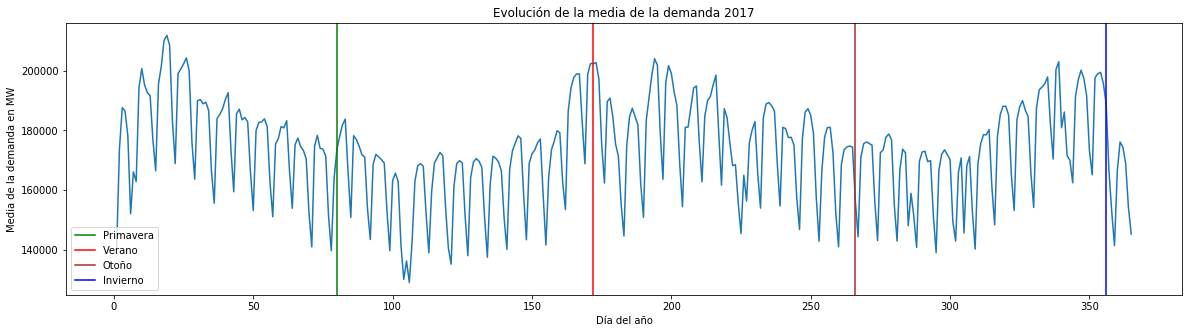

In [32]:
plt.figure(figsize=(20,5))
plt.plot(range(1,366), mediaDemanda2017)
plt.axvline(x=80, c='green', label = 'Primavera')
plt.axvline(x=172, c='red', label = 'Verano')
plt.axvline(x=266, c='brown', label = 'Otoño')
plt.axvline(x=356, c='blue', label = 'Invierno')
plt.title('Evolución de la media de la demanda 2017')
plt.xlabel('Día del año')
plt.ylabel('Media de la demanda en MW')
plt.legend()
plt.show()

En esta gráfica vemos como la demanda sufre un incremento en épocas de invierno o verano, en las que se hace más uso de calefactores o aires acondicionados, y cómo decrece en épocas como otoño o primavera, cuando la temperatura tiende a tener valores más estables.

A continuación podemos ver una gráfica de barras, que nos muestra cómo varía la media de consumo durante un día, en función del día de la semana que es.

In [33]:
mediaDemandaPorTipoDia = media_tipo_de_dia(data_d) # Función 4

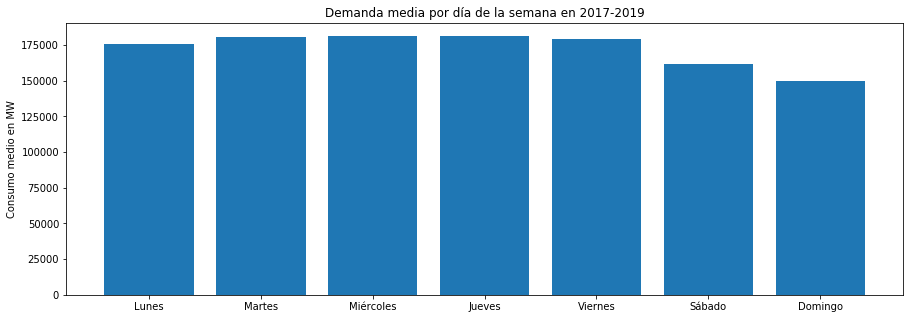

In [34]:
plt.figure(figsize=(15,5))
plt.title('Demanda media por día de la semana en 2017-2019')
plt.ylabel('Consumo medio en MW')
plt.bar(['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'],mediaDemandaPorTipoDia[0:7])
plt.show()

Observamos en esta gráfica cómo los días de más demanda suelen ser en mitad de la semana laboral (martes, miércoles, jueves). Por otro lados los demás días parecen tener una menor demanda, en orden descendiente de demanda serían: viernes, lunes, sabado y domingo.

A continuación, veremos una gráfica de barras que compara la demanda media de días festivos, previos a festivos, medias de demanda de cada año y la media global del dataset. Además para que sirva de referencia con el gráfico anterior, he añadido la columna del miércoles y la del domingo.   

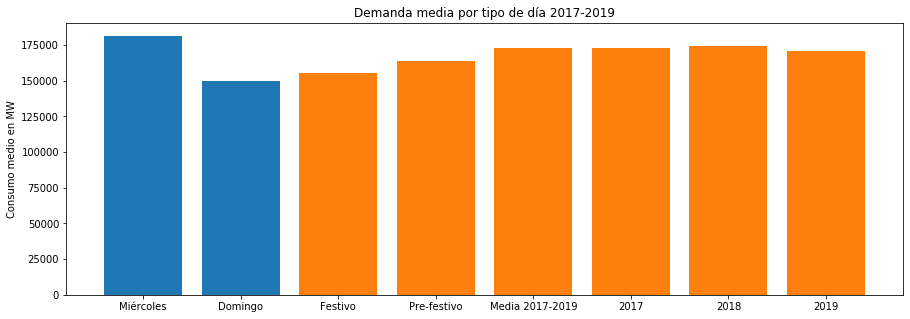

In [35]:
plt.figure(figsize=(15,5))
plt.title('Demanda media por tipo de día 2017-2019')
plt.ylabel('Consumo medio en MW')
plt.bar(['Miércoles', 'Domingo'],[mediaDemandaPorTipoDia[2],mediaDemandaPorTipoDia[6]])
plt.bar(['Festivo','Pre-festivo','Media 2017-2019','2017','2018','2019'],mediaDemandaPorTipoDia[7:-4])
plt.show()

Podemos observar como los días festivos y previos a un festivo también tienen una media de demanda menor que la media global del dataset. Por otro lado, también parece ser que la demanda de 2017, 2018 y 2019 son prácticamente iguales.

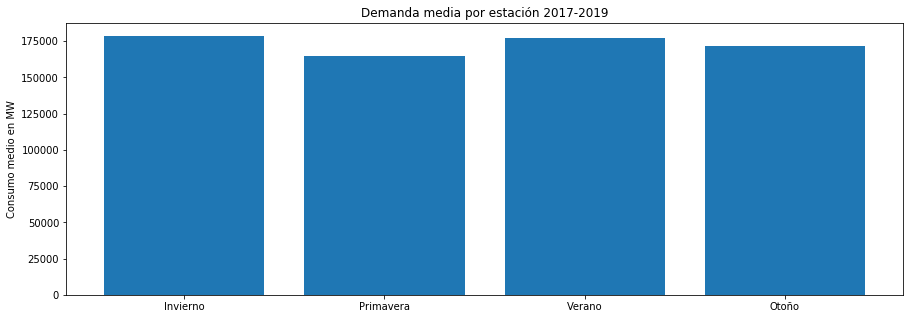

In [36]:
plt.figure(figsize=(15,5))
plt.title('Demanda media por estación 2017-2019')
plt.ylabel('Consumo medio en MW')
plt.bar(['Invierno','Primavera','Verano','Otoño'],mediaDemandaPorTipoDia[-4:])
plt.show()

Podemos también ver como parace que la demanda en invierno y en verano es mayor que en primavera y en verano.

Ahora vamos a estudiar la demanda por horas:

In [37]:
mediasPorHorasDemanda = media_horas(data_d) # Función 5

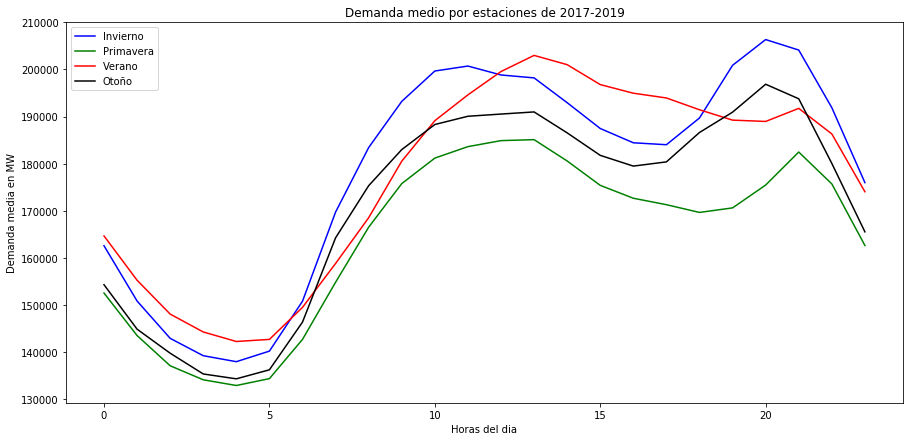

In [38]:
plt.figure(figsize=(15,7))
plt.title('Demanda medio por estaciones de 2017-2019')
plt.xlabel('Horas del dia')
plt.ylabel('Demanda media en MW')
plt.plot(range(0,24),mediasPorHorasDemanda[0], color='blue', label='Invierno')
plt.plot(range(0,24),mediasPorHorasDemanda[1], color='green', label='Primavera')
plt.plot(range(0,24),mediasPorHorasDemanda[2], color='red', label='Verano')
plt.plot(range(0,24),mediasPorHorasDemanda[3], color='black', label='Otoño')
plt.legend()
plt.show()

Podemos observar como parece ser que todas las estaciones siguen un patrón muy similar, solamente aumentando o disminuyendo el valor de la demanda, excepto el verano. En verano parece que la demanda se mantiene más constante durante la tarde, después de haber alcanzado el pico que hay alrededor del medio día.

Ahora vamos a comparar dos gráficas:

1. La primera gráfica será identica a la anterior, pero con el añadido de que podremos ver la media por horas de la demanda de los días festivos y los previos a los festivos.


2. La segunda gráfica nos comparará también la media de demanda por horas de días festivos y previos festivos, pero añadirá también la de los días normales (que no son previos a festivos ni festivos).

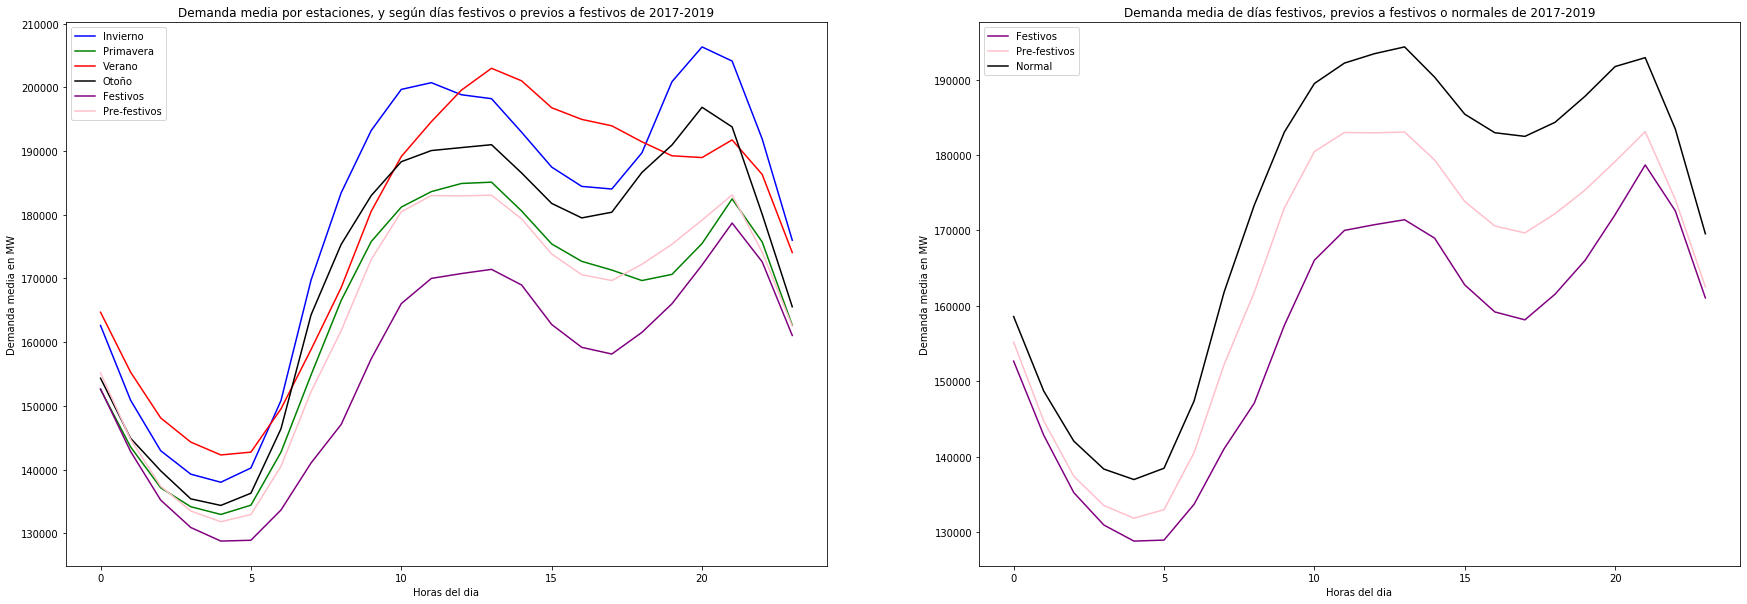

In [39]:
fig,(axis1,axis2)=plt.subplots(1,2)
fig.set_size_inches(30,10)

# Configuración de gráfica 1
axis1.set_title('Demanda media por estaciones, y según días festivos o previos a festivos de 2017-2019')
axis1.set_xlabel('Horas del dia')
axis1.set_ylabel('Demanda media en MW')
axis1.plot(range(0,24),mediasPorHorasDemanda[0], color='blue', label='Invierno')
axis1.plot(range(0,24),mediasPorHorasDemanda[1], color='green', label='Primavera')
axis1.plot(range(0,24),mediasPorHorasDemanda[2], color='red', label='Verano')
axis1.plot(range(0,24),mediasPorHorasDemanda[3], color='black', label='Otoño')
axis1.plot(range(0,24),mediasPorHorasDemanda[4], color='purple', label='Festivos')
axis1.plot(range(0,24),mediasPorHorasDemanda[5], color='pink', label='Pre-festivos')
axis1.legend()

# Configuración de gráfica 2
axis2.set_title('Demanda media de días festivos, previos a festivos o normales de 2017-2019')
axis2.set_xlabel('Horas del dia')
axis2.set_ylabel('Demanda media en MW')
axis2.plot(range(0,24),mediasPorHorasDemanda[4], color='purple', label='Festivos')
axis2.plot(range(0,24),mediasPorHorasDemanda[5], color='pink', label='Pre-festivos')
axis2.plot(range(0,24),mediasPorHorasDemanda[6], color='black', label='Normal')
axis2.legend()

plt.show()

Con estas dos gráficas podemos ver que los días previos a festivos la demanda es menor, pero además, que los días festivos tienen una demanda incluso menor a la de días previos a festivos.

Con toda esta información vamos a recopilar los indicios que hemos visto.

**Resumen de indicios obtenidos:**

- En primavera y otoño hay menos demanda, mientras que en verano e invierno se dan las medias mas altas.
- El patrón de demanda horario durante estaciones es muy similar, aunque el verano es el que más varía.
- En verano la demanda durante la tarde tiende a ser más constante que otras estaciones.
- Los días festivos y previos a festivos tienen menos demanda que los días normales.
- Los picos de demanda durante la semana se dan entre el martes y el jueves.
- Durante el fin de semana la demanda disminuye.

### 3.B.- Proceso de clustering sobre la demanda:

Primero debemos de definir exactamente las columnas que vamos a utilizar para realizar el proceso de clustering. Para ello voy a escoger solamente las columnas de las horas:

In [40]:
clusteringD = data_d.loc[:,'0':'23']
clusteringD.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,146834,141117,132157,124264,118132,115424,115966,117857,117670,120636,...,148568,141087,137795,140318,156288,165457,171563,175309,172195,159458.0
1,143914,130578,122994,119329,118373,122091,134985,153716,169952,183225,...,196514,191353,189032,192392,203517,207996,209675,208212,197361,180042.0
2,163693,149531,139874,136777,135006,138748,151426,173025,192361,207595,...,206627,200819,198672,201358,212371,215953,217262,214419,202046,184097.0
3,167281,152964,144316,140374,139189,141540,153715,175226,192779,206505,...,202160,196757,195004,197124,207352,211739,211690,211427,201631,184728.0
4,168956,153819,145109,140653,139125,141012,151185,170638,186695,200409,...,193182,185370,182776,182361,189880,191182,190835,190856,182893,171684.0


Es muy importante que tengamos los valores del dataset normalizados, porque si no lo hacemos, al tener números tan grandes, las distancias que vamos a obtener pueden verse distorsionadas. Para normalizar el dataset, vamos a aplicarle la siguiente fórmula:

\begin{align}
z_{i,j} = \frac{x_{i,j}-\min{(x_{*,j})}}{\max{(x_{*,j})}-\min{(x_{*,j})}} 
                                                           \quad \quad \text{$\min{(x_{*,j})}$ = mínimo de la columna j}\\
                                                           \quad \quad \text{$\max{(x_{*,j})}$ = máximo de la columna j}\\
                                                           \quad \quad \text{$x_{i,j}$ = elemento de la fila i, columna j}\\
                                                           \quad \quad \text{$z_{i,j}$ = resultado}\\
\end{align}

In [41]:
clusteringD_norm = (clusteringD-clusteringD.min())/(clusteringD.max()-clusteringD.min())
clusteringD_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.347916,0.412393,0.180327,0.329878,0.255855,0.207472,0.158225,0.102724,0.069645,0.035633,...,0.148289,0.156095,0.151897,0.160994,0.268513,0.320082,0.331461,0.289169,0.412364,0.409858
1,0.304318,0.254916,0.112976,0.248289,0.259918,0.319919,0.428454,0.469433,0.513367,0.563120,...,0.610419,0.609636,0.605727,0.634028,0.688864,0.681661,0.671735,0.648384,0.696407,0.691141
2,0.599633,0.538118,0.237050,0.536752,0.540355,0.600860,0.662054,0.666895,0.703554,0.768505,...,0.707894,0.695046,0.691113,0.715474,0.767667,0.749295,0.739474,0.716148,0.749286,0.746553
3,0.653204,0.589415,0.269701,0.596221,0.610882,0.647951,0.694577,0.689403,0.707102,0.759319,...,0.664839,0.658396,0.658624,0.677013,0.722997,0.713476,0.689725,0.683483,0.744602,0.755176
4,0.678213,0.602191,0.275530,0.600833,0.609803,0.639045,0.658629,0.642485,0.655467,0.707943,...,0.578304,0.555653,0.550315,0.542908,0.567491,0.538743,0.503527,0.458901,0.533110,0.576928


También creo que puede resultar interesante mostrar la matriz de distancias de la demanda, para que podamos ver visualmente, la distancia que separa a cada uno de los elementos del dataset respecto a los demás. La funcion distance_matrix() del paquete de scipy.espatial implementa la distancia de Minkowski:

\begin{align}
Distancia = (\sum_{k=1}^n (x_{i,k}-x_{j,k})^P)^\frac{1}{P} 
                                                           \quad \quad \text{$x_{i,k}$ = propiedad k de elemento i}\\
                                                           \quad \quad \text{$x_{j,k}$ = propiedad k de elemento j}\\
\end{align}

Si a la para la fórmula de la distancia de Minkowski establecemos que $P = 2$, obtendremos la distancia euclídea:

\begin{align}
Distancia = \sqrt{\sum_{k=1}^n (x_{i,k}-x_{j,k})^2}
                                                           \quad \quad \text{$x_{i,k}$ = propiedad k de elemento i}\\
                                                           \quad \quad \text{$x_{j,k}$ = propiedad k de elemento j}\\
\end{align}

In [42]:
from scipy.spatial import distance_matrix
matriz_distancias_demanda = pd.DataFrame(distance_matrix(clusteringD_norm,clusteringD_norm,p=2)) #distancia euclídea
matriz_distancias_demanda.head()

,0,1,2,3,4,5,6,7,8,9,...,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094
0,0.000000,1.870903,2.452725,2.388887,2.049784,0.659140,1.329018,1.146737,2.808012,3.100549,...,0.516511,1.194248,0.998207,0.968768,1.043418,1.190521,0.745611,0.427101,1.318095,1.075865
1,1.870903,0.000000,0.859278,0.933435,0.963768,1.420079,0.712341,0.980073,1.110445,1.525298,...,1.597000,0.947285,1.742623,2.520719,1.446929,0.903238,1.257331,1.575487,0.707241,1.195801
2,2.452725,0.859278,0.000000,0.198881,0.659537,1.873230,1.138077,1.376253,0.428978,0.699094,...,2.217193,1.575074,2.307398,3.193668,2.200566,1.545893,1.861745,2.206499,1.361574,1.740682
3,2.388887,0.933435,0.198881,0.000000,0.534548,1.789813,1.086456,1.309097,0.552465,0.730968,...,2.171684,1.558692,2.267748,3.151910,2.203814,1.532732,1.819749,2.160570,1.357611,1.708197
4,2.049784,0.963768,0.659537,0.534548,0.000000,1.428904,0.866616,1.089236,1.044352,1.196595,...,1.802263,1.238673,1.848759,2.773849,1.908637,1.222357,1.463790,1.812664,1.087731,1.320454


In [43]:
matriz_distancias_demanda.shape

(1095, 1095)

Esta matriz tiene 1095 filas y 1095 columnas porque muestra las distancias que tiene cada elemento del dataset respecto a todos los demás del cluster. Por eso mismo será simétrica y todos los valores en su diagonal serán 0, pues la distancia de un elemento $i$ al mismo elemento $i$ será 0.


Ahora podemos empezar el proceso de clusterización del dataset de la demanda. Para ello voy a usar 2 formas diferentes, para comprobar que el resultado obtenido es correcto de cualquiera de las dos formas.


### Clustering jerárquico:

Con este algoritmo, cada dato del dataset comienza siendo un cluster independiente, y poco a poco, se irán juntando hasta formar un único cluster. Exactamente el procedimiento será el siguiente:

1. Empezamos con cada observación del dataset siendo considerada como un cluster.


2. Encontramos los dos datos que tienene una menos distancia en la matriz de distancia, y los unimos en un mismo cluster.


3. Recalculamos la distancia entre los clusters antiguos y el nuevo con alguno de los métodos de enlace.


4. Repetir el paso 2 y 3 hasta que solo quede un único cluster que recoja el total de muestras anteriores.






Para este estudio, el método de enlace que voy a usar es el método de enlace de Ward:

\begin{align}
E_k = \min({\sum_{i=1}^k \sum_{x_i \epsilon C_i} (x_{i}-c_{j})^2)}
\end{align}

El método de enlace de Ward es un procedimiento jerárquico donde cada etapa une los dos clusters que provoquen un menor incremento en la suma de los cuadrados de las diferencias, dentro de cada cluster, de sus individuos. 

Para empezar con el proceso clustering jerarquico vamos a comenzar visualizando el dendrograma que obtenemos al aplicarlo:

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage
dendrograma_demanda = linkage(clusteringD_norm,'ward')

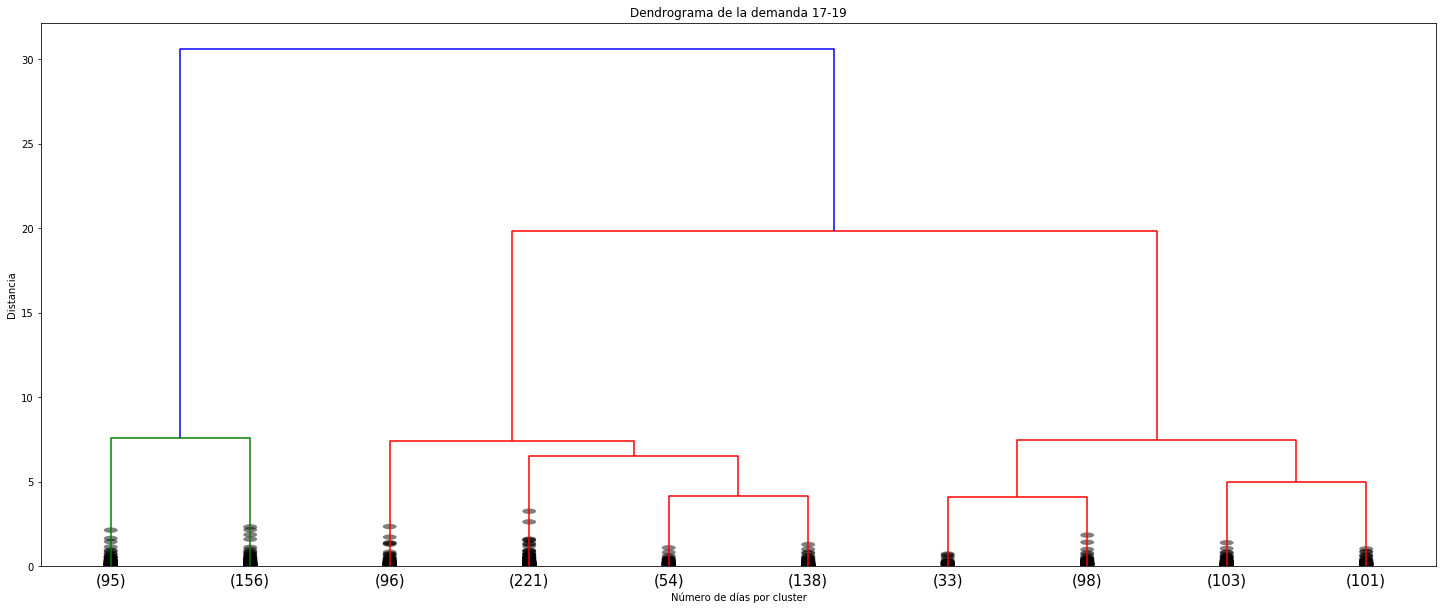

In [45]:
plt.figure(figsize=(25,10))
plt.title('Dendrograma de la demanda 17-19')
plt.xlabel('Número de días por cluster')
plt.ylabel('Distancia')
dendrogram(dendrograma_demanda, truncate_mode='lastp',p=10,show_leaf_counts=True,show_contracted=True,leaf_font_size=15)
plt.show()

Para que el dendrograma no se haga tan pesado de visualizar, ya que esta representando 1095 datos, he decidido truncarlo para que solo muestre a partir de 10 clusters. También he añadido la opción para que muestre puntos en las alturas donde se unirían los distintos clusters, y que muestre debajo de cada cluster cuantos elementos hay agrupados.

Ahora para determinar con cuantos clusters nos vamos a quedar, vamos a usar el método del codo:

In [46]:
distancias, crecimiento = get_distancia_crecimiento(dendrograma_demanda,10) #Fución 6

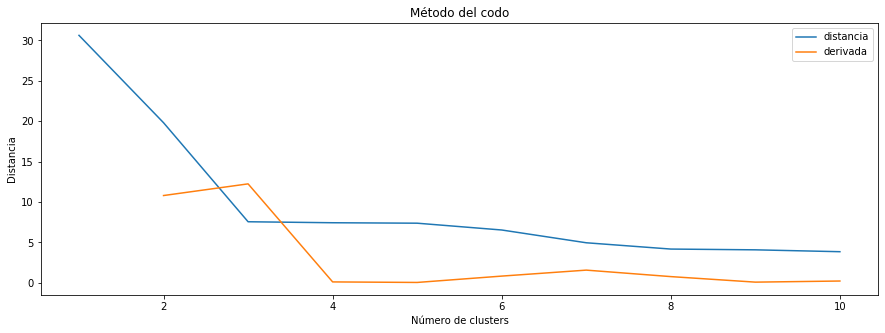

In [47]:
plt.figure(figsize=(15,5))
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia')
plt.plot(range(1,len(distancias)+1), distancias, label='distancia')
plt.plot(range(2,len(crecimiento)+2), crecimiento, label='derivada')
plt.legend()
plt.show()

El método del codo consiste en estudiar el ritmo al que crece la distancia que separa (diferencia) a cada uno de los clusters que va uniendo.

En la gráfica, la línea azul representa el aumento de la distancia, y la naranja la derivada de la distancia. Por lo que podemos ver como si establecemos menos de 3 clusters, la distancia se dispara, lo que provoca que veamos en el punto 3 el codo de la gráfica. 

Por todo esto podemos establecer que el número óptimo de clusters que debería de tener nuestro dataset es 3, por lo cual el dendrograma debería de cortarse de la siguiente forma:

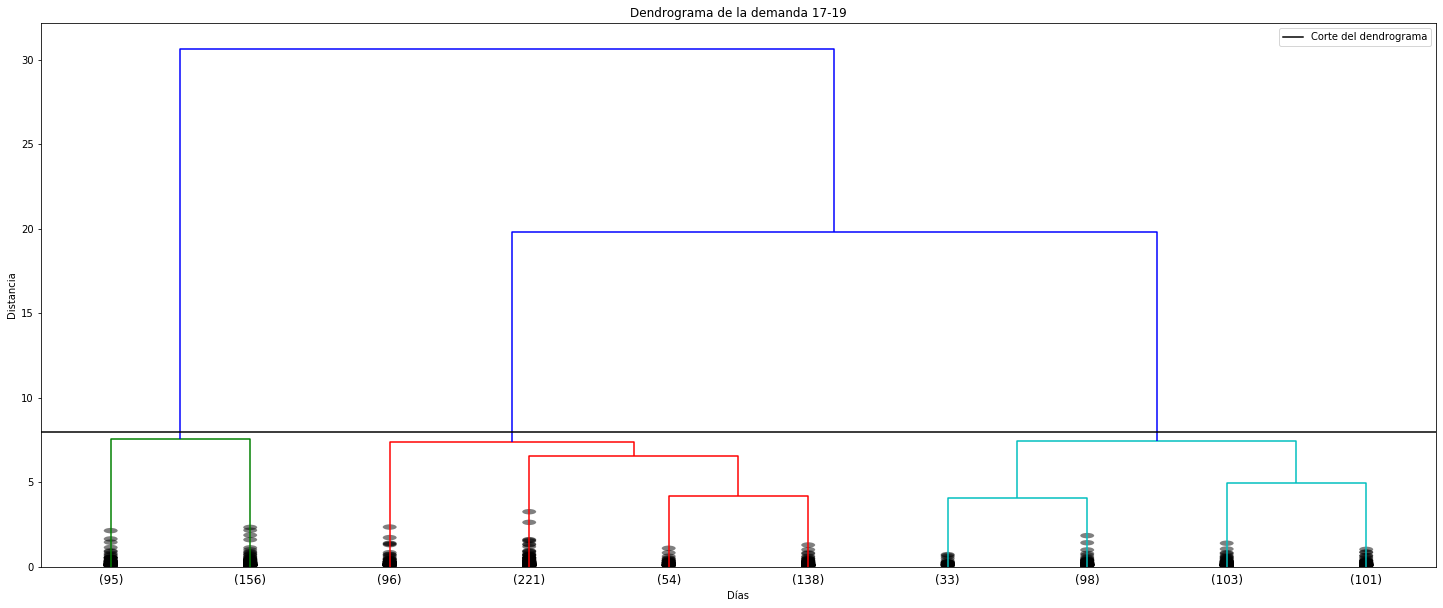

In [48]:
plt.figure(figsize=(25,10))
plt.title('Dendrograma de la demanda 17-19')
plt.xlabel('Días')
plt.ylabel('Distancia')
dendrogram(dendrograma_demanda, truncate_mode='lastp',p=10,show_leaf_counts=True,
           show_contracted=True,color_threshold=8)
plt.axhline(y=8,color='black',linestyle='-', label='Corte del dendrograma')
plt.legend()
plt.show()

### K-means:

K-means es otro algoritmo de clustering, pero este parte con la desventaja de que para poder utilizarlo hay que establecerle un número de clusters. 

Para resolver este problema voy a ir inicializando el modelo con diferentes valores para el número de clusters, con el fin de obtener los coeficientes de las siluetas de cada modelo, para poder establecer cúal es el número óptimo de clusters.

El coeficiente de la silueta se calcula con la distancia promedio intracluster y la menor distancia de cada punto a cualquier cluster más cercano:

\begin{align}
S(i) = \frac{b(i)-a(i)}{\max{(a(i),b(i))}} \quad \quad -1\leq S(i)\leq1
\end{align}

El valor de $S(i)$ nos indicará cómo de bien estan agrupados los elementos de un cluster, de forma que si $S(i)$ tiende a 1, los elementos estarán muy bien agrupados, y de que si $S(i)$ tiende a -1, los elementos estarán muy mal agrupados.

Para K igual a 2 la media de la silueta es: 0.4320928602680151
Para el cluster 0 la silueta vale: 0.3824040307434613
Para el cluster 1 la silueta vale: 0.478703620706977


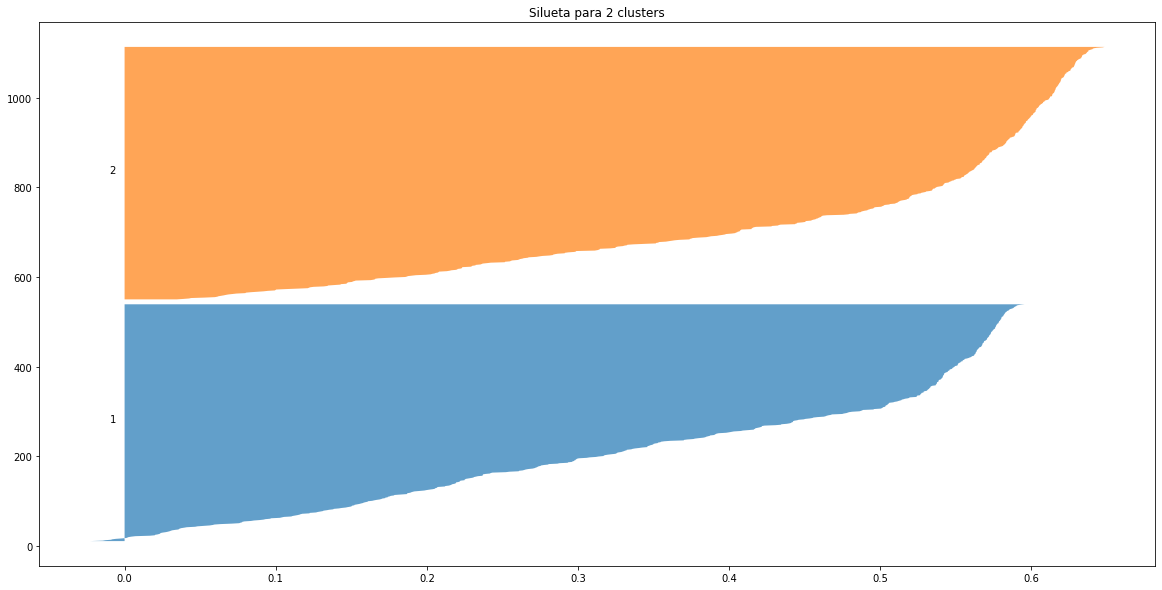

Para K igual a 3 la media de la silueta es: 0.42320996833188795
Para el cluster 0 la silueta vale: 0.4146609415108766
Para el cluster 1 la silueta vale: 0.46818964286163306
Para el cluster 2 la silueta vale: 0.4061056415775113


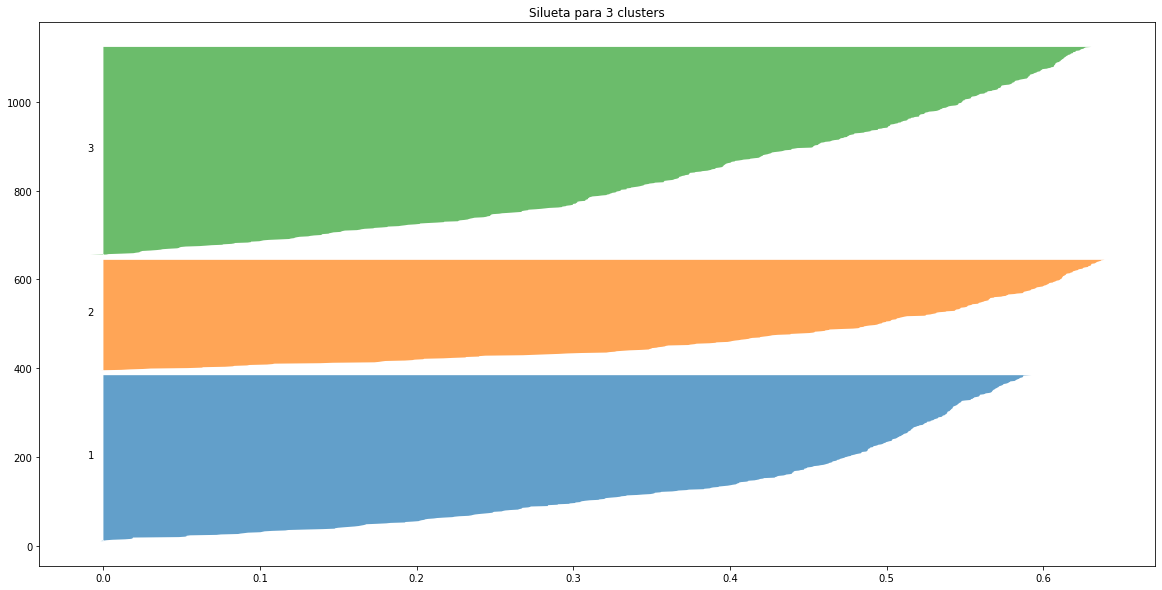

Para K igual a 4 la media de la silueta es: 0.3427953964187942
Para el cluster 0 la silueta vale: 0.3294680789240577
Para el cluster 1 la silueta vale: 0.4556392964597313
Para el cluster 2 la silueta vale: 0.3434057956364344
Para el cluster 3 la silueta vale: 0.2717669247776914


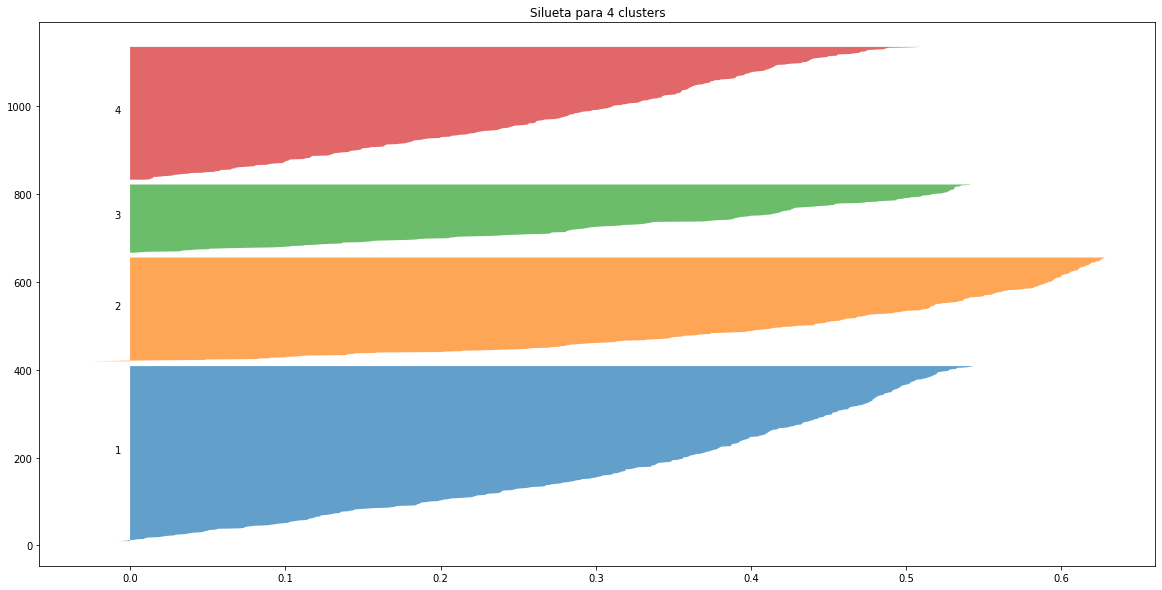

Para K igual a 5 la media de la silueta es: 0.32967104408161346
Para el cluster 0 la silueta vale: 0.33901194655821915
Para el cluster 1 la silueta vale: 0.2855158770467888
Para el cluster 2 la silueta vale: 0.4757602960982963
Para el cluster 3 la silueta vale: 0.2836950840854142
Para el cluster 4 la silueta vale: 0.35190586664993456


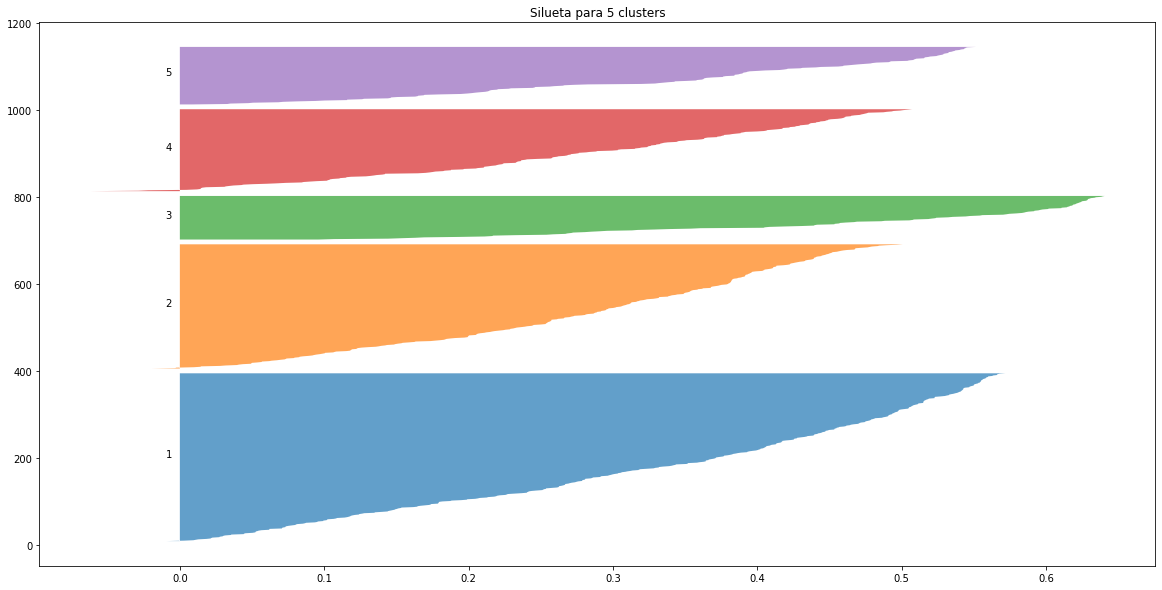

In [49]:
analiza_siluetas(clusteringD_norm,5) # Función 7

Como podemos observar en el resultado obtenido, los mejores medios para las siluetas son para 2 y para 3 clusters, sin embargo, los valores de las siluetas individuales para 2 clusters, tienen peores valores que las siluetas individuales para 3 clusters. Por esto, considero que el valor óptimo de clusters, obtenido con el modelo de K-means, es 3.

Una vez que estoy seguro que el número óptimo de clusters es 3, ya que lo he obtenido tanto con el clustering jerarquico, como en K-means, procedo a añadirle, al dataset de la demanda, una columna que indique a que cluster pertenece cada fila. Para esto me quedare con la clasificación obtenida con el clustering jerárquico.

In [50]:
from sklearn.cluster import AgglomerativeClustering

clus_D = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(clusteringD_norm)
data_d['cluster'] = pd.Series(clus_D)
data_d.head()

,date,0,1,2,3,4,5,6,7,8,...,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo,cluster
0,2017-01-01,146834,141117,132157,124264,118132,115424,115966,117857,117670,...,171563,175309,172195,159458.0,2017,6,0,1,0,0
1,2017-01-02,143914,130578,122994,119329,118373,122091,134985,153716,169952,...,209675,208212,197361,180042.0,2017,0,0,0,0,2
2,2017-01-03,163693,149531,139874,136777,135006,138748,151426,173025,192361,...,217262,214419,202046,184097.0,2017,1,0,0,0,1
3,2017-01-04,167281,152964,144316,140374,139189,141540,153715,175226,192779,...,211690,211427,201631,184728.0,2017,2,0,0,0,1
4,2017-01-05,168956,153819,145109,140653,139125,141012,151185,170638,186695,...,190835,190856,182893,171684.0,2017,3,0,0,1,2


### 3.C.- Caracterizar los clusters obtenidos de la de demanda:

En esta parte intentaremos averiguar que representa cada uno de los clusters de la demanda, que hemos obtenido en el apartado anterior. Para ello vamos a dividir los datos según los 3 clusters obtenidos, y generar las matrices de contingencia:

In [51]:
cluster0_demanda = data_d.loc[data_d.cluster==0,:]
cluster1_demanda = data_d.loc[data_d.cluster==1,:]
cluster2_demanda = data_d.loc[data_d.cluster==2,:]

clusters_demanda = [cluster0_demanda, cluster1_demanda, cluster2_demanda]

In [52]:
años, estaciones, dias, tipo_dia = genera_matrices_contencion(clusters_demanda,data_d)# Función 8
años

,2017,2018,2019
Cluster,,,
0,22.191781,22.465753,24.109589
1,28.493151,37.534247,25.753425
2,49.315068,40.000000,50.136986
Total:,100.000000,100.000000,100.000000


In [53]:
estaciones

,Invierno,Primavera,Verano,Otoño
cluster,,,,
0.0,20.973783,29.347826,16.666667,24.814815
1.0,43.445693,5.434783,44.326241,29.259259
2.0,35.580524,65.217391,39.007092,45.925926
Total:,100.000000,100.000000,100.000000,100.000000


In [54]:
dias

,Lunes,Martes,Miércoles,Jueves,Viernes,Sábado,Domingo
Cluster,,,,,,,
0,4.458599,3.821656,2.564103,4.487179,3.846154,51.282051,89.808917
1,28.662420,48.407643,48.076923,48.717949,40.384615,0.000000,0.000000
2,66.878981,47.770701,49.358974,46.794872,55.769231,48.717949,10.191083
Total:,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [55]:
tipo_dia

,Festivo,Pre-festivo,Normales
Cluster,,,
0,64.705882,41.176471,19.571865
1,11.764706,16.176471,32.313965
2,23.529412,42.647059,48.114169
Total:,100.000000,100.000000,100.000000


In [56]:
mean_day(cluster0_demanda).mean()

149611.86985391765

Además voy a mostrar la demanda media por cluster:

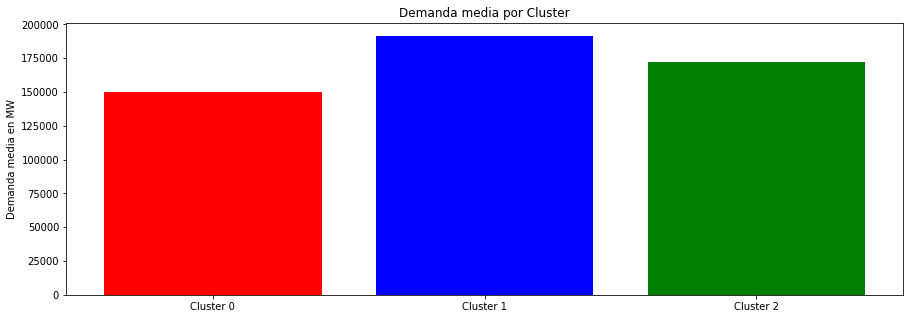

In [57]:
plt.figure(figsize=(15,5))
plt.title('Demanda media por Cluster')
plt.ylabel('Demanda media en MW')
plt.bar(['Cluster 0','Cluster 1','Cluster 2'],[mean_day(cluster0_demanda).mean(),mean_day(cluster1_demanda).mean()
        ,mean_day(cluster2_demanda).mean()],color=['red','blue','green'])
plt.show()

Con estas matrices de contingencia, y esta gráfica de barras, podemos ver algunos datos interesantes sobre los clusters, por ejemplo:

- El cluster 0 tiene: el 89% de los domingos, el 51% de los sábados, el 64% de los festivos, el 42% de los días previos a un festivo y que es el cluster que menos demanda media tiene.


- El cluster 1 tiene: el 43% de los inviernos, el 44% de los veranos, sin embargo tiene el un 0% de sábados y domingos y un 28% de los lunes, que junto a los días del finde semana, era uno de los días con menos demanda. Además es el cluster que más media de consumo tiene.


- El cluster 2 tiene: un 66% de los lunes, un 65% de los días de primavera, un 48% de los días normales, un 42% de los días previos a un festivo, y es el cluster que tiene una demanda media.

A partir de esto, podemos sacar las conclusiones sobre la caracterización de cada cluster.

**Conclusiones:**

- Cluster 0: Días con poca demanda, como: fin de semanas, días festivos y algunos días previos a festivos.


- Cluster 1: Días de mucha demanda, como: días de verano e invierno, y los martes, miércoles y jueves.


- Cluster 2: Días de demanda media, como: días de primavera y otoño, los lunes y viernes y algunos días previos a festivos.

### 3.D.- Exploración de datos de los precios

En esta parte realizaremos una exploración inicial de los datos de los datos del precio, para estudiar las columnas del dataset y explorar tendencias del dataset, al igual que hicimos con la demanda.

El dataset inicial que tenemos para realizar el estudio tiene el siguiente tamaño:

In [58]:
precios.shape

(1095, 25)

A continuación procederé a mostrar los 5 primeros datos del dataset:

In [59]:
precios.head()

,date,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2017-01-01,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,...,120.95,120.15,120.83,127.76,134.42,135.79,137.63,132.23,129.79,121.53
1,2017-01-02,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,...,128.04,127.02,127.31,136.53,140.28,141.97,138.66,134.19,130.78,129.82
2,2017-01-03,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,...,138.93,138.66,138.89,139.75,141.50,142.64,145.28,142.51,142.26,139.56
3,2017-01-04,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,...,137.84,135.87,136.71,141.10,144.29,145.16,145.13,140.49,137.25,134.17
4,2017-01-05,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,...,139.61,139.33,137.68,141.74,142.33,143.88,142.67,142.33,138.63,142.45


Al igual que con la demanda, volveré a añadir columnas extras al dataset para poder obtener más información.

In [60]:
data_p = define_dataset(precios) # Función 1
data_p.head()

,date,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo
0,2017-01-01,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,...,135.79,137.63,132.23,129.79,121.53,2017,6,0,1,0
1,2017-01-02,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,...,141.97,138.66,134.19,130.78,129.82,2017,0,0,0,0
2,2017-01-03,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,...,142.64,145.28,142.51,142.26,139.56,2017,1,0,0,0
3,2017-01-04,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,...,145.16,145.13,140.49,137.25,134.17,2017,2,0,0,0
4,2017-01-05,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,...,143.88,142.67,142.33,138.63,142.45,2017,3,0,0,1


**Análisis de los datos que contiene nuestro dataset.**

Cada fila de nuestro dataset representa a un día que va en el periodo de tiempo que transcure entre el 1 de enero de 2017 y el 31 de diciembre de 2019.

Por otro lado, las features o columnas de nuestro dataset son:

- date: es un string que representa la fecha del día que representa esa línea.


- columnas númericas que van de 0 a 23: identifican la cantidad de demanda en MW registrada en cada una de las 24 horas del día.


- año: simbolizan el año al que pertence cada fila.


- día de la semana: marca el día de la semana que es cada fila. Las claves son las siguientes:

    0. Lunes
    1. Martes
    2. Miércoles
    3. Jueves
    4. Viernes
    5. Sábado
    6. Domingo
    
    
- estación: establece la estación a la que pertenece cada fila. Las claves son las siguientes:

    0. Invierno
    1. Primavera
    2. Verano
    3. Otoño
    
- festivo: representa si un día es festivo.

- pre-festivo: indica si un día es previo a un festivo.


**Limpieza de valores faltantes del dataset.**

Como podemos comprobar, en nuestro dataset tenemos algunos valores que faltan:

In [61]:
data_p.isna().sum()

date           0
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
20             0
21             0
22             0
23             3
año            0
dia_semana     0
estacion       0
festivo        0
pre-festivo    0
dtype: int64

Estos valores faltantes, al igual que antes, se dan por el adelanto de la hora, para adecuarse al horario de verano. Por eso mismo, volveré a hacer uso de la función ``arregla_dias()`` para que rellene esos valores vacíos.

In [62]:
data_p = arregla_dias(data_p)

demanda del día  84 (Hora, demanda) = 23    NaN
Name: 84, dtype: object
demanda del día  77 (Hora, demanda) = 23    117.79
Name: 77, dtype: object
demanda del día  84 (Hora, demanda) = 23    117.79
Name: 84, dtype: object
demanda del día  448 (Hora, demanda) = 23    NaN
Name: 448, dtype: object
demanda del día  441 (Hora, demanda) = 23    113.79
Name: 441, dtype: object
demanda del día  448 (Hora, demanda) = 23    113.79
Name: 448, dtype: object
demanda del día  819 (Hora, demanda) = 23    NaN
Name: 819, dtype: object
demanda del día  812 (Hora, demanda) = 23    105.55
Name: 812, dtype: object
demanda del día  819 (Hora, demanda) = 23    105.55
Name: 819, dtype: object


Podemos comprobar como ya no hay ningún valor faltante en el dataset:

In [63]:
data_p.isna().sum()

date           0
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
20             0
21             0
22             0
23             0
año            0
dia_semana     0
estacion       0
festivo        0
pre-festivo    0
dtype: int64

**Exploración gráfica.**

Ahora, al igual que antes, vamos a proceder a estudiar gráficamente los datos, con el objetivo de encontrar indicios que nos ayuden en nuestor posterior trabajo de clustering.

In [64]:
mediaPorHorasPrecio = mean_day(data_p)

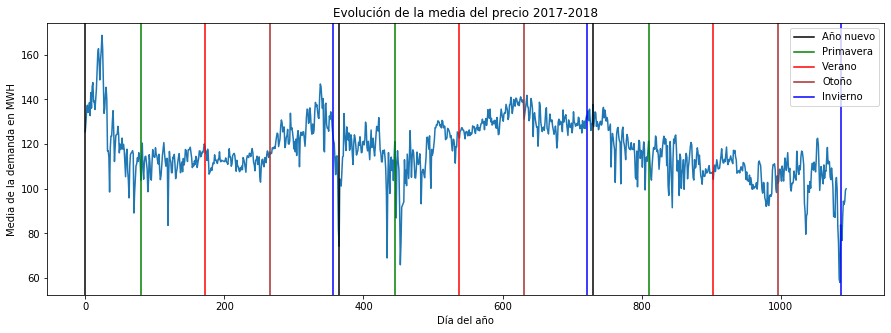

In [65]:
plt.figure(figsize=(15,5))
plt.plot(range(0,1095), mediaPorHorasPrecio)
for i in range(0,3):
    if i == 0:
        plt.axvline(x=0+365*i, c='black', label='Año nuevo')
        plt.axvline(x=80+365*i, c='green', label='Primavera')
        plt.axvline(x=172+365*i, c='red', label='Verano')
        plt.axvline(x=266+365*i, c='brown', label='Otoño')
        plt.axvline(x=356+365*i, c='blue', label='Invierno')
    else:
        plt.axvline(x=0+365*i, c='black')
        plt.axvline(x=80+365*i, c='green')
        plt.axvline(x=172+365*i, c='red')
        plt.axvline(x=266+365*i, c='brown')
        plt.axvline(x=356+365*i, c='Blue')
plt.title('Evolución de la media del precio 2017-2018')
plt.xlabel('Día del año')
plt.ylabel('Media de la demanda en MWH')
plt.legend()
plt.show()

Podemos observar como, a diferencia de antes, la evolución del precio a lo largo de los 3 años no parece seguir una cierta periodicidad. Esto seguramente se deberán a motivos externos como la economía o política. Por este motivo, al realizar el proceso de clustering tendré encuenta el año en el que está ubicado cada dato.

In [66]:
valoresPrecioBar = media_tipo_de_dia(data_p)

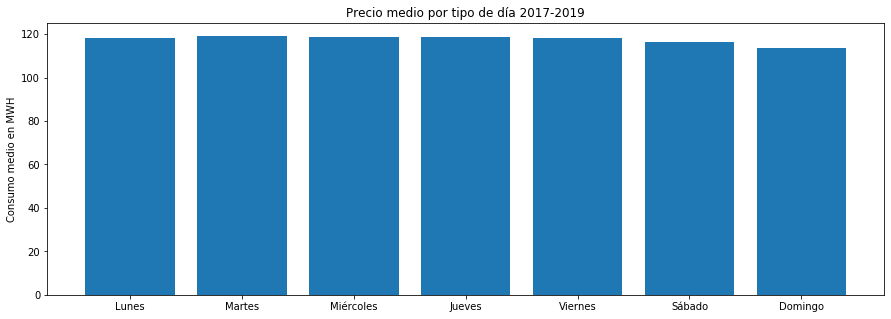

In [67]:
plt.figure(figsize=(15,5))
plt.title('Precio medio por tipo de día 2017-2019')
plt.ylabel('Consumo medio en MWH')
plt.bar(['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'],valoresPrecioBar[:7])
plt.show()

Aquí podemos percibir como el precio parece serguir un poco de la tendencia de la demanda, subiendo martes, miércoles y jueves, aunque el aumento es mucho mas leve que en la demanda.

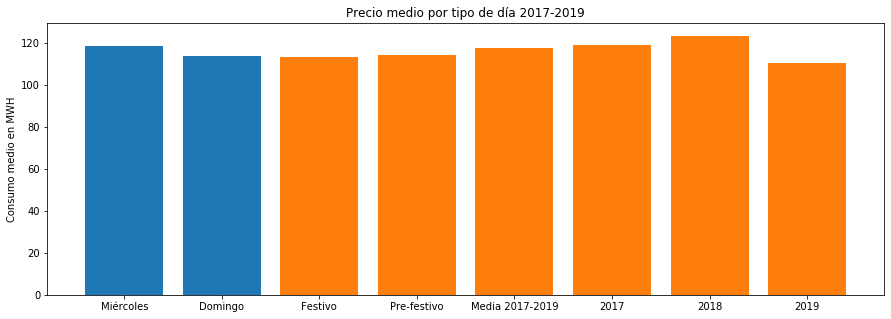

In [68]:
plt.figure(figsize=(15,5))
plt.title('Precio medio por tipo de día 2017-2019')
plt.ylabel('Consumo medio en MWH')
plt.bar(['Miércoles', 'Domingo'],[valoresPrecioBar[2],valoresPrecioBar[6]])
plt.bar(['Festivo','Pre-festivo','Media 2017-2019','2017','2018','2019'],valoresPrecioBar[7:-4])
plt.show()

En esta gráfica, al igual que hice en la demanda, analizaremos el precio según el tipo de día y por años, demás, se encuentran presentes el dato de miércoles y domingo para que sirvan de referencia.

Podemos observar como el precio en festivos y previos a festivos es un poco más bajo, al igual que en los domingos. Además, en este dataset si que difiere más la media de los precios de un año para otro.

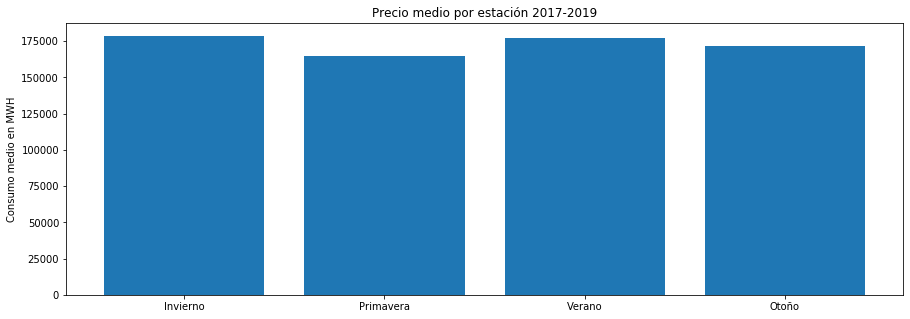

In [69]:
plt.figure(figsize=(15,5))
plt.title('Precio medio por estación 2017-2019')
plt.ylabel('Consumo medio en MWH')
plt.bar(['Invierno','Primavera','Verano','Otoño'],valoresPrecioBar[-4:])
plt.show()

Aquí, al igual que pasó con la demanda, podemos ver como parece que los precios bajan en primavera y otoño, mientras que suben en invierno y verano. A pesar de esto, los cambios no son tan grandes como los vistos en la demanda.

Ahora vamos a pasar a estudiar cómo varían los precios a lo largo de las horas.

In [70]:
mediasPorHorasPrecios = media_horas(data_p) # Función 5

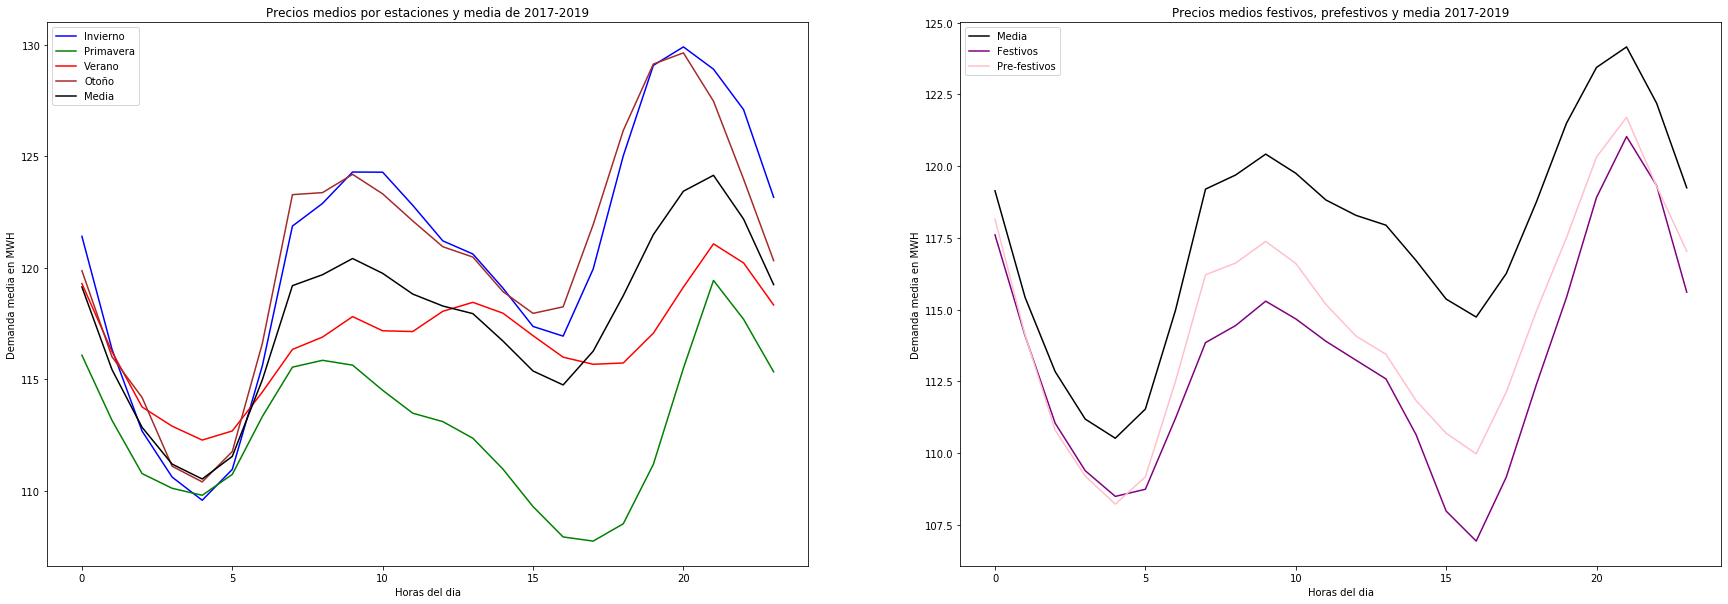

In [71]:
fig,(axis1,axis2)=plt.subplots(1,2)
fig.set_size_inches(30,10)
# configuración gráfica 1
axis1.set_title('Precios medios por estaciones y media de 2017-2019')
axis1.set_xlabel('Horas del dia')
axis1.set_ylabel('Demanda media en MWH')
axis1.plot(range(0,24),mediasPorHorasPrecios[0], color='blue', label='Invierno')
axis1.plot(range(0,24),mediasPorHorasPrecios[1], color='green', label='Primavera')
axis1.plot(range(0,24),mediasPorHorasPrecios[2], color='red', label='Verano')
axis1.plot(range(0,24),mediasPorHorasPrecios[3], color='brown', label='Otoño')
axis1.plot(range(0,24),mediasPorHorasPrecios[6], color='black', label='Media')
axis1.legend()

# configuración gráfica 2
axis2.set_title('Precios medios festivos, prefestivos y media 2017-2019')
axis2.set_xlabel('Horas del dia')
axis2.set_ylabel('Demanda media en MWH')
axis2.plot(range(0,24),mediasPorHorasPrecios[6], color='black', label='Media')
axis2.plot(range(0,24),mediasPorHorasPrecios[4], color='purple', label='Festivos')
axis2.plot(range(0,24),mediasPorHorasPrecios[5], color='pink', label='Pre-festivos')
axis2.legend()
plt.show()

En estas gráficas podemos ver: cómo la curva de la primavera es mucho más baja que las demás, y que los días festivos, y previos a los festivos, tienen una curva similar a la media, pero con precios más bajos.

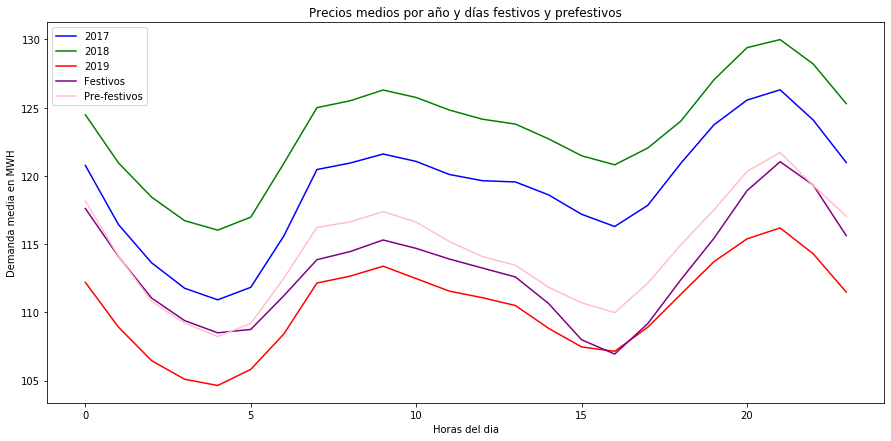

In [72]:
plt.figure(figsize=(15,7))
plt.title('Precios medios por año y días festivos y prefestivos')
plt.xlabel('Horas del dia')
plt.ylabel('Demanda media en MWH')
plt.plot(range(0,24),mediasPorHorasPrecios[7], color='blue', label='2017')
plt.plot(range(0,24),mediasPorHorasPrecios[8], color='green', label='2018')
plt.plot(range(0,24),mediasPorHorasPrecios[9], color='red', label='2019')
plt.plot(range(0,24),mediasPorHorasPrecios[4], color='purple', label='Festivos')
plt.plot(range(0,24),mediasPorHorasPrecios[5], color='pink', label='Pre-festivos')
plt.legend()
plt.show()

Aqui simplemente podemos ver como todas las líneas tienen curvas similares, y que la media de 2019 es más baja que la media de los días festivos y previos a festivos del dataset.

Con todos estos datos ya podemos recapitular para ver que indicios hemos encontrado.

**Indicios obtenidos:**

- El precio ha ido variando por años en este orden descendiente: 2018-2017-2019.
- El precio baja en días pre-festivos y aun más en festivos.
- El precio baja en otoño y aun más en primavera.


### 3.E- Proceso de clustering sobre los precios:

Al igual que antes, primero de todo vamos a definir sobre qué columnas vamos a trabajar. Esta vez, al visualizar los datos, hemos visto como el precio ha variado mucho en función del año, por lo que considero que para este proceso de clustering, además de las horas, voy a escoger la columna de los años.

In [73]:
clusteringP= data_p.loc[:,'0':'año']
clusteringP.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,año
0,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,116.78,...,120.15,120.83,127.76,134.42,135.79,137.63,132.23,129.79,121.53,2017
1,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,131.35,...,127.02,127.31,136.53,140.28,141.97,138.66,134.19,130.78,129.82,2017
2,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,139.06,...,138.66,138.89,139.75,141.50,142.64,145.28,142.51,142.26,139.56,2017
3,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,144.58,...,135.87,136.71,141.10,144.29,145.16,145.13,140.49,137.25,134.17,2017
4,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,138.79,...,139.33,137.68,141.74,142.33,143.88,142.67,142.33,138.63,142.45,2017


Una vez más procedemos a normalizar el dataset:

In [74]:
clusteringP_norm = (clusteringP-clusteringP.min())/(clusteringP.max()-clusteringP.min())
clusteringP_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,año
0,0.610490,0.675619,0.398231,0.673176,0.668639,0.659736,0.653341,0.566011,0.533522,0.511510,...,0.583257,0.599201,0.610367,0.652621,0.623439,0.640080,0.591807,0.581832,0.528033,0.0
1,0.580415,0.574077,0.348844,0.614497,0.615585,0.635712,0.669773,0.632197,0.652282,0.639037,...,0.646112,0.659418,0.687155,0.702404,0.673218,0.648637,0.607866,0.589978,0.598454,0.0
2,0.563311,0.578583,0.345163,0.579191,0.591014,0.635611,0.726380,0.729083,0.702629,0.706521,...,0.752608,0.767029,0.715349,0.712769,0.678615,0.703639,0.676034,0.684440,0.681193,0.0
3,0.645590,0.618957,0.379498,0.661440,0.659914,0.679015,0.783889,0.768655,0.738762,0.754836,...,0.727081,0.746771,0.727169,0.736471,0.698913,0.702393,0.659484,0.643216,0.635406,0.0
4,0.539154,0.554410,0.358952,0.620414,0.565339,0.588877,0.680994,0.686467,0.686360,0.704158,...,0.758737,0.755785,0.732773,0.719820,0.688602,0.681954,0.674560,0.654571,0.705742,0.0


Y como dato interesante, volveré a generar la matriz de distancias, aunque esta vez, será del dataset de los precios:

In [75]:
matriz_distancias_precios = pd.DataFrame(distance_matrix(clusteringP_norm,clusteringP_norm,p=2)) #distancia euclídea
matriz_distancias_precios.head()

,0,1,2,3,4,5,6,7,8,9,...,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094
0,0.000000,0.361652,0.629960,0.655018,0.614097,0.519464,0.643801,0.413088,0.956063,0.617249,...,3.067208,2.171211,2.275209,2.349014,2.000755,1.710878,1.744235,1.698477,1.561968,1.503422
1,0.361652,0.000000,0.312092,0.360550,0.294086,0.274844,0.401294,0.297882,0.648884,0.318586,...,3.242769,2.260091,2.387738,2.512708,2.106567,1.823341,1.882188,1.837044,1.657066,1.628290
2,0.629960,0.312092,0.000000,0.197918,0.115990,0.208741,0.292397,0.406250,0.392623,0.147283,...,3.471738,2.447076,2.586861,2.731855,2.303564,2.023432,2.095688,2.046058,1.845792,1.831973
3,0.655018,0.360550,0.197918,0.000000,0.262030,0.274971,0.236367,0.429636,0.322751,0.120503,...,3.563708,2.553120,2.690737,2.828952,2.403473,2.112004,2.179549,2.133554,1.932297,1.907200
4,0.614097,0.294086,0.115990,0.262030,0.000000,0.212128,0.311436,0.394876,0.447187,0.212995,...,3.432573,2.405533,2.544890,2.692310,2.262709,1.986213,2.057991,2.008064,1.812358,1.798853


In [76]:
matriz_distancias_precios.shape

(1095, 1095)

También volveré a realizar el proceso de clustering con el clustering jerárquico y con K-means.

### Clustering jerárquico:

In [77]:
dendrograma_precios = linkage(clusteringP_norm,'ward')

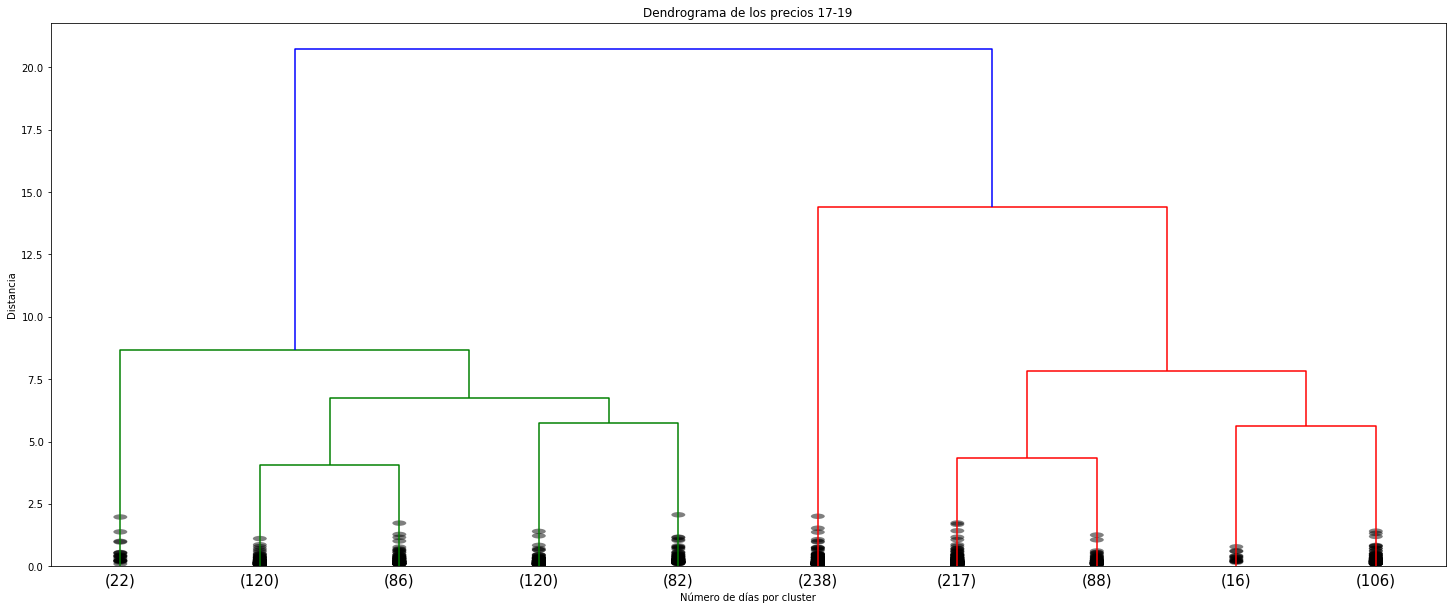

In [78]:
plt.figure(figsize=(25,10))
plt.title('Dendrograma de los precios 17-19')
plt.xlabel('Número de días por cluster')
plt.ylabel('Distancia')
dendrogram(dendrograma_precios, truncate_mode='lastp',p=10,show_leaf_counts=True,show_contracted=True,leaf_font_size=15)
plt.show()

In [79]:
distancias_precios, crecimiento_precios = get_distancia_crecimiento(dendrograma_precios,10) #Fución 6

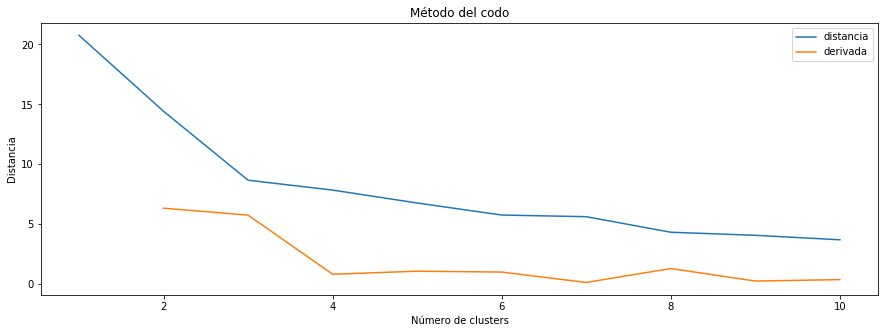

In [80]:
plt.figure(figsize=(15,5))
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia')
plt.plot(range(1,len(distancias_precios)+1), distancias_precios, label='distancia')
plt.plot(range(2,len(crecimiento_precios)+2), crecimiento_precios, label='derivada')
plt.legend()
plt.show()

Una vez más, gracias al método del codo, volvemos a ver cómo el mejor número de clusters es 3.

Vamos a visualizar cómo se quedaría el dendrograma cortando para que se nos queden 3 clusters.

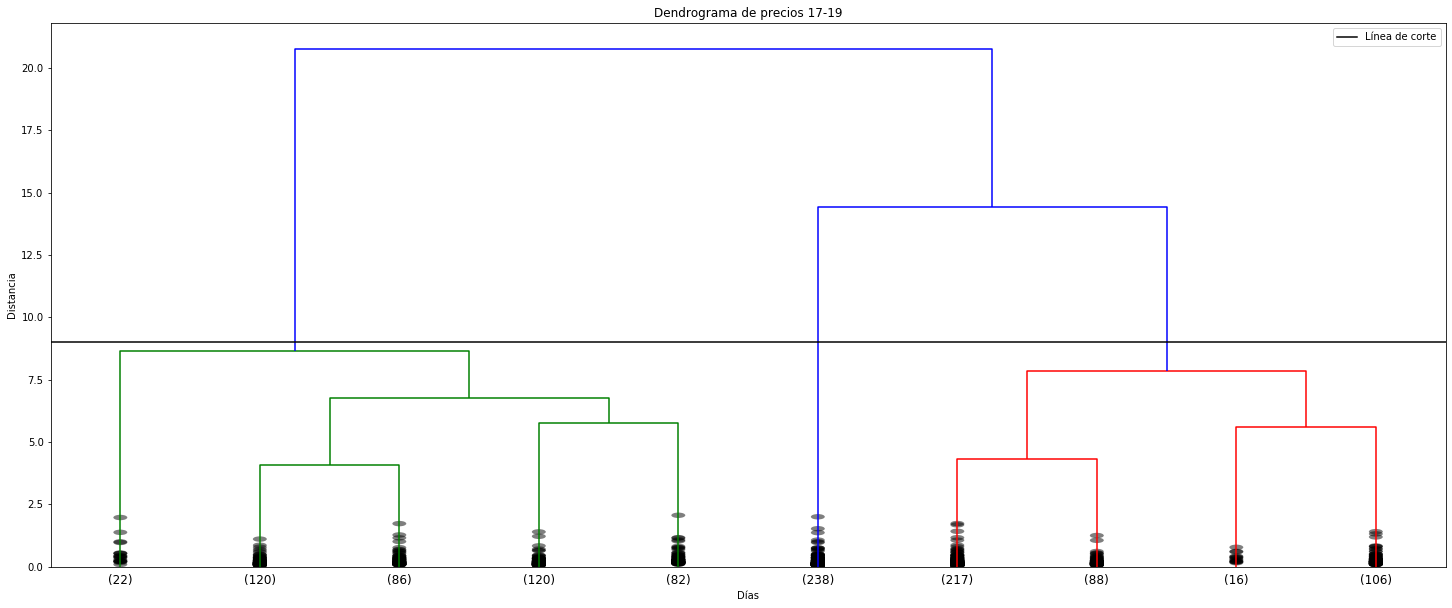

In [81]:
plt.figure(figsize=(25,10))
plt.title('Dendrograma de precios 17-19')
plt.xlabel('Días')
plt.ylabel('Distancia')
dendrogram(dendrograma_precios, truncate_mode='lastp',p=10,show_leaf_counts=True,
           show_contracted=True,color_threshold=9)
plt.axhline(y=9,color='black',linestyle='-',label='Línea de corte')
plt.legend()
plt.show()

### K-means:

De nuevo, al igual que hicimos con la demanda, realizaremos una análisis de las siluetas del dataset de los precios para un número de clusters K.

Para K igual a 2 la media de la silueta es: 0.38379683706640955
Para el cluster 0 la silueta vale: 0.4192714118463014
Para el cluster 1 la silueta vale: 0.36354019321792036


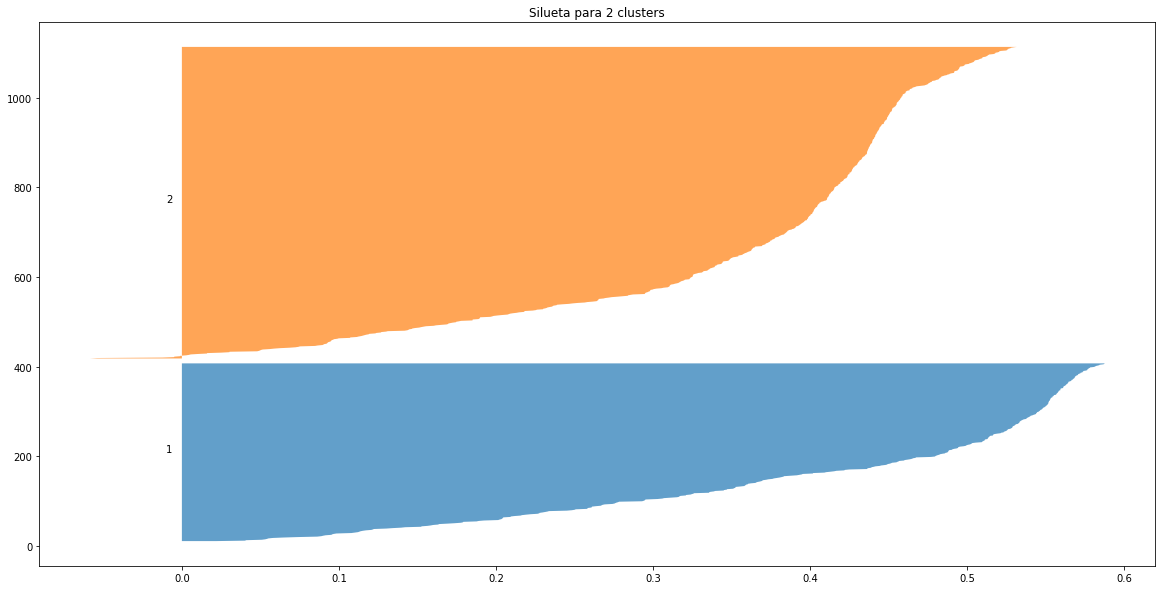

Para K igual a 3 la media de la silueta es: 0.3976077586854932
Para el cluster 0 la silueta vale: 0.42749803938008907
Para el cluster 1 la silueta vale: 0.40218628024851105
Para el cluster 2 la silueta vale: 0.3641800123741523


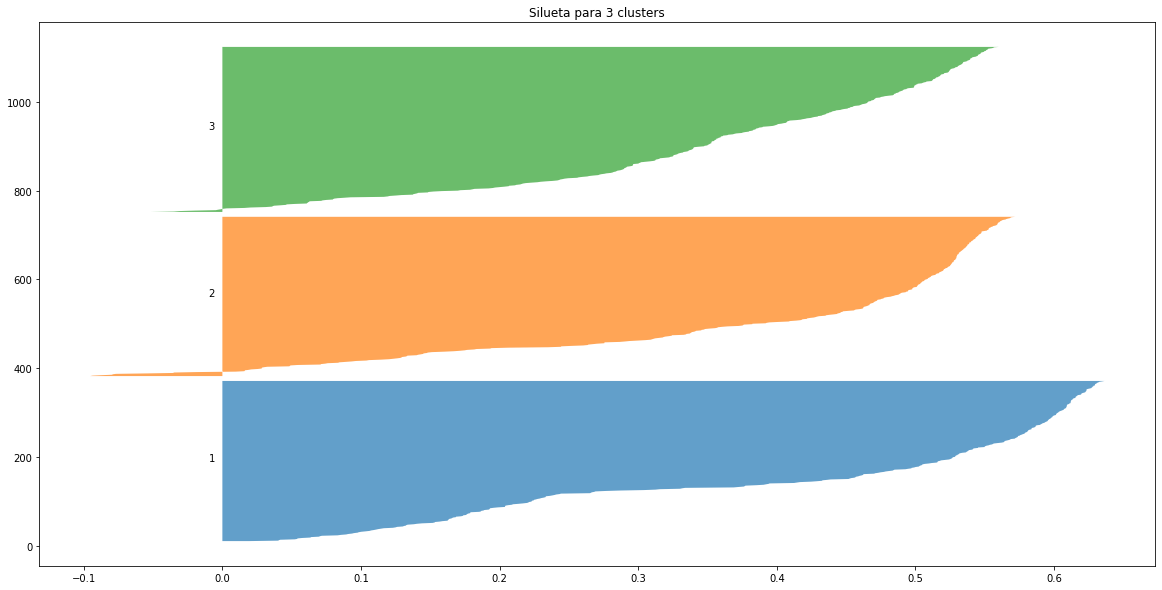

Para K igual a 4 la media de la silueta es: 0.3837815898953433
Para el cluster 0 la silueta vale: 0.3223516711424014
Para el cluster 1 la silueta vale: 0.5447702402821313
Para el cluster 2 la silueta vale: 0.37169219269745823
Para el cluster 3 la silueta vale: 0.21226439244901316


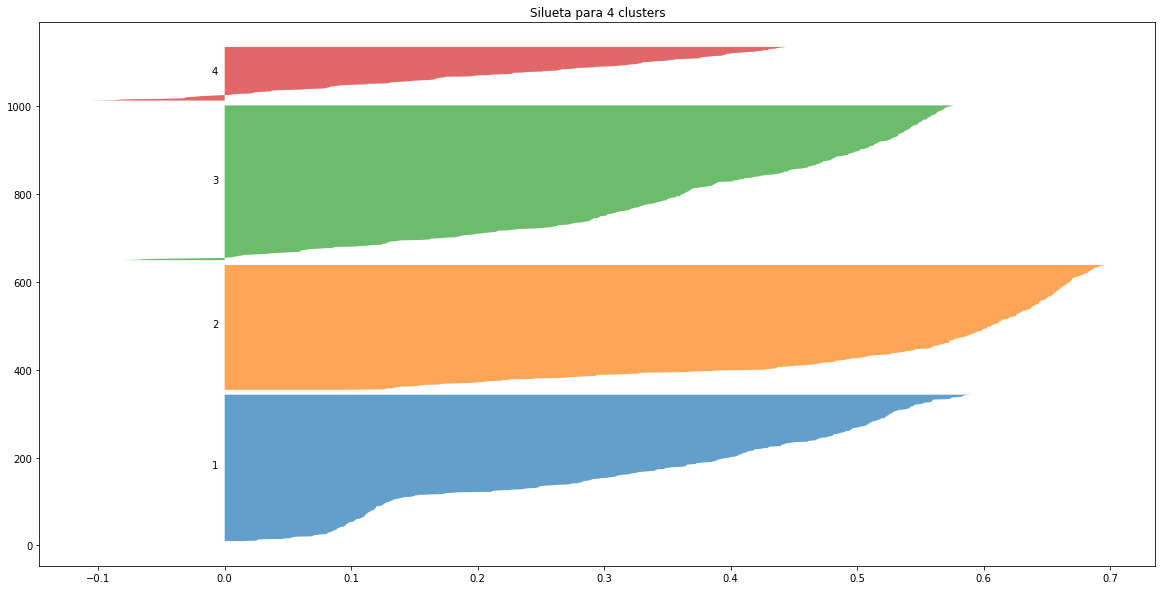

Para K igual a 5 la media de la silueta es: 0.38821426738551224
Para el cluster 0 la silueta vale: 0.5359825425210868
Para el cluster 1 la silueta vale: 0.18748272613630418
Para el cluster 2 la silueta vale: 0.28688281241440194
Para el cluster 3 la silueta vale: 0.4222632179494003
Para el cluster 4 la silueta vale: 0.32271248572725664


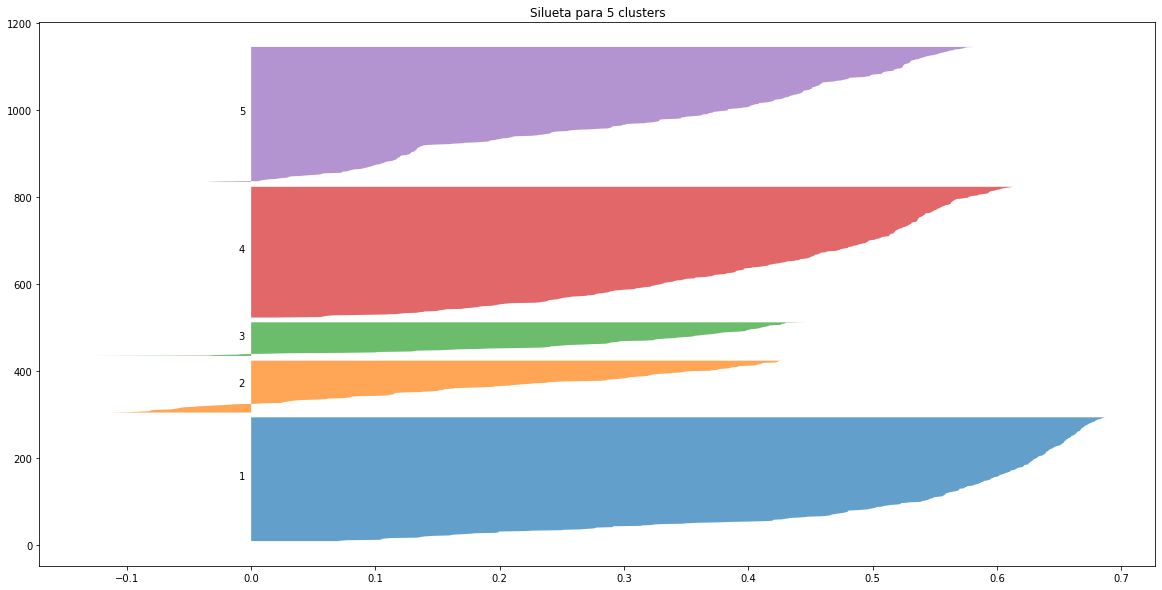

In [82]:
analiza_siluetas(clusteringP_norm,5) # Función 7

El analisís nos muestra que el número de clusters, según la media de las siluetas y los valores individuales de cada silueta, es 3.

Ya que tanto el clustering jerárquico, como K-means, concuerdan en que el número óptimo de clusters es 3, procedo a añadirle al dataset de los precios, una columna que indique a que cluster pertenece cada fila.

In [83]:
clus_P = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(clusteringP_norm)
data_p['cluster'] = pd.Series(clus_P)
data_p.head()

,date,0,1,2,3,4,5,6,7,8,...,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo,cluster
0,2017-01-01,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,...,137.63,132.23,129.79,121.53,2017,6,0,1,0,1
1,2017-01-02,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,...,138.66,134.19,130.78,129.82,2017,0,0,0,0,1
2,2017-01-03,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,...,145.28,142.51,142.26,139.56,2017,1,0,0,0,1
3,2017-01-04,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,...,145.13,140.49,137.25,134.17,2017,2,0,0,0,1
4,2017-01-05,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,...,142.67,142.33,138.63,142.45,2017,3,0,0,1,1


### 3.C.- Caracterizar los clusters obtenidos de los precios:

En esta parte intentaremos averiguar qué representa cada uno de los clusters obtenidos anteriormente. Para ello nos apoyaremos en unas matrices de contingencia, iguales que las que generamos para la demanda, para poder analizar diferentes perspectivas de los clusters. Además analizaremos gráfico de barras que nos mostrará el precio medio de cada cluster:

In [84]:
cluster0_precios = data_p.loc[data_p.cluster==0,:]
cluster1_precios = data_p.loc[data_p.cluster==1,:]
cluster2_precios = data_p.loc[data_p.cluster==2,:]

clusters_precios = [cluster0_precios, cluster1_precios, cluster2_precios]

In [85]:
años, estaciones, dias, tipo_dia = genera_matrices_contencion(clusters_precios,data_p)# Función 8
años

,2017,2018,2019
Cluster,,,
0,1.095890,25.205479,91.506849
1,33.698630,74.794521,8.493151
2,65.205479,0.000000,0.000000
Total:,100.000000,100.000000,100.000000


In [86]:
estaciones

,Invierno,Primavera,Verano,Otoño
cluster,,,,
0.0,39.325843,50.362319,33.333333,34.074074
1.0,47.940075,16.666667,33.333333,58.888889
2.0,12.734082,32.971014,33.333333,7.037037
Total:,100.000000,100.000000,100.000000,100.000000


In [87]:
dias

,Lunes,Martes,Miércoles,Jueves,Viernes,Sábado,Domingo
Cluster,,,,,,,
0,38.216561,38.853503,36.538462,37.820513,37.820513,41.025641,44.585987
1,40.764331,40.764331,42.307692,41.025641,41.666667,35.256410,31.210191
2,21.019108,20.382166,21.153846,21.153846,20.512821,23.717949,24.203822
Total:,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [88]:
tipo_dia

,Festivo,Pre-festivo,Normales
Cluster,,,
0,50.0,51.470588,38.226300
1,25.0,27.941176,39.857288
2,25.0,20.588235,21.916412
Total:,100.0,100.000000,100.000000


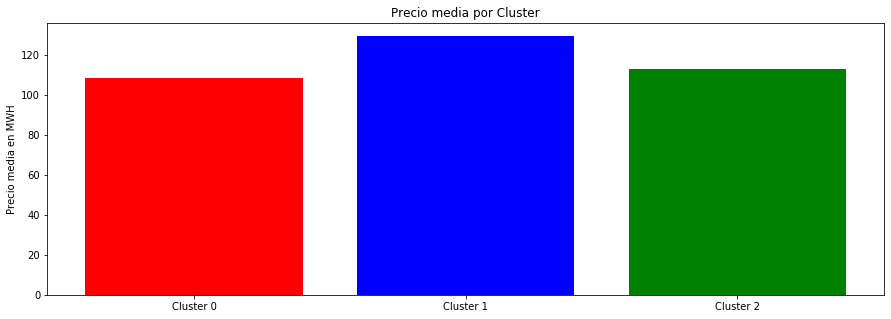

In [89]:
plt.figure(figsize=(15,5))
plt.title('Precio media por Cluster')
plt.ylabel('Precio media en MWH')
plt.bar(['Cluster 0','Cluster 1','Cluster 2'],[mean_day(cluster0_precios).mean(),mean_day(cluster1_precios).mean()
        ,mean_day(cluster2_precios).mean()],color=['red','blue','green'])
plt.show()

Con estas matrices de contingencia, y esta gráfica de barras, podemos ver algunos datos interesantes sobre los clusters, como que:

- El cluster 0 tiene: el 91% de los días de 2019, el 50% de los días de primavera, el 50% de los días festivos, el 51% de los días pre-festivos y es el cluster que menos precio medio tiene .


- El cluster 1 tiene: el 74% de los días de 2018, el 58% de los días de otoño, el 47'9% de los días inviernos y es el cluster que más precio medio.


- El cluster 2 tiene: el 65% de los días de 2017 y un 0% de los días de 2018 y 2019.

A partir de esto, podemos sacar las conclusiones sobre la caracterización de cada cluster.

**Conclusiones:**

- Cluster 0: Días con precio bajo, como: los días de 2019, y los días del año con menos precio como suelen ser los días de primavera, festivos y previos a festivos. 


- Cluster 1: Días con precio alto, como: los días de 2018, los días de invierno y días de otoño.


- Cluster 2: Días con un precio medio, como: los días de 2017, que fué el año en el que el precio se mantuvo en un valor medio comparado con los valores de los otros años.

## 4.- Relacionar ambas series obtenidas.

En este apartado intentaremos de buscar de qué manera puede influir la demanda en el precio, con la finalidad de buscar relaciones que nos ayuden a precedecir la variación de los precios, o por el contrario, si la demanda y el precio no siguen la ley de la oferta y la demanda, debido a que este mercado esta muy intervenido externamente.


  ### 4.A.- Análisis de la correlación entre demanda y precios:
  
Primero de todo, intentaremos estudiar las correlaciones que pueden tener las diferentes demandas (demanda hace una hora, demanda hace una semana, etc...) con el precio.

Para estudiar la correlación, haremos uso del coeficiente de correlación de Pearson:

\begin{align}
r = \frac{\sum_{i=1}^n (x_i - X)(y_i - Y)}{\sqrt{\sum_{i=1}^n (x_i - X)^2 \sum_{i=1}^n(y_i-Y)^2}}
                                                           \quad \quad \text{$x_{i}$ = valor de elemento i de la columna x}\\
                                                           \quad \quad \text{$y_{i}$ = valor de elemento i de la columna y}\\
                                                           \quad \quad \text{$x_{i}$ = valor medio de la columna x}\\
                                                           \quad \quad \text{$y_{i}$ = valor medio de la columna y}\\
\end{align}

Pero antes de todo, comenzaremos creando un dataset que recoja los datos de diferentes demandas con unos retrasos en el tiempo.
Además, como el coeficiente de correlación de Pearson, sólo estudia la relación líneal entre dos variables, añadiremos también algunas columnas con algunas transformaciones matemáticas sobre los datos del precio. Esto lo haremos para comprobar si las correlaciones que se dan son, por ejemplo, de forma cuadrática o logarítmica:

In [90]:
data4 = pd.DataFrame() 
data4['precios'] = convierte_en_serie_horas(precios) #Función 9
data4['precios$^2$'] = demanda_retrasada(precios,0,exp=2)
data4['$\sqrt{precios}$'] = demanda_retrasada(precios,0,exp=1/2)
data4['$\log_{10}{(precios)}$'] = demanda_retrasada_log(precios,0,10)
data4['demanda-1h'] = demanda_retrasada(demanda,1,exp=1)
data4['demanda-2h'] = demanda_retrasada(demanda,2,exp=1)
data4['demanda-3h'] = demanda_retrasada(demanda,3,exp=1)
data4['demanda-1s'] = demanda_retrasada(demanda,168,exp=1)
data4['demanda-1s-1h'] = demanda_retrasada(demanda,169,exp=1)
data4['demanda-1s-2h'] = demanda_retrasada(demanda,170,exp=1)
data4['demanda-1s-3h'] = demanda_retrasada(demanda,171,exp=1)
data4['demanda-1a'] = demanda_retrasada(demanda,8760,exp=1)
data4['demanda-1a-1h'] = demanda_retrasada(demanda,8761,exp=1)
data4['demanda-1a-2h'] = demanda_retrasada(demanda,8762,exp=1)
data4['demanda-1a-3h'] = demanda_retrasada(demanda,8763,exp=1)
data4.head()

,precios,precios$^2$,$\sqrt{precios}$,$\log_{10}{(precios)}$,demanda-1h,demanda-2h,demanda-3h,demanda-1s,demanda-1s-1h,demanda-1s-2h,demanda-1s-3h,demanda-1a,demanda-1a-1h,demanda-1a-2h,demanda-1a-3h
0,132.63,17590.7169,11.516510,2.122642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,135.59,18384.6481,11.644312,2.132228,146834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,129.90,16874.0100,11.397368,2.113609,141117.0,146834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125.38,15720.1444,11.197321,2.098228,132157.0,141117.0,146834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123.84,15336.3456,11.128342,2.092861,124264.0,132157.0,141117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Una vez que hemos obtenido los datos, eliminamos las casillas con valor NaN obtenidas al haber desplazado las muestras en el tiempo:

In [91]:
data4 = data4.loc[8763:,:]
data4.isna().sum()

precios                   0
precios$^2$               0
$\sqrt{precios}$          0
$\log_{10}{(precios)}$    0
demanda-1h                0
demanda-2h                0
demanda-3h                0
demanda-1s                0
demanda-1s-1h             0
demanda-1s-2h             0
demanda-1s-3h             0
demanda-1a                0
demanda-1a-1h             0
demanda-1a-2h             0
demanda-1a-3h             0
dtype: int64

Y visualizamos nuestro DataFrame limpio:

In [92]:
data4.head()

,precios,precios$^2$,$\sqrt{precios}$,$\log_{10}{(precios)}$,demanda-1h,demanda-2h,demanda-3h,demanda-1s,demanda-1s-1h,demanda-1s-2h,demanda-1s-3h,demanda-1a,demanda-1a-1h,demanda-1a-2h,demanda-1a-3h
8763,69.48,4827.4704,8.335466,1.841860,124299.0,132750.0,136969.0,120470.0,127737.0,136467.0,143298.0,124264.0,132157.0,141117.0,146834.0
8764,70.25,4935.0625,8.381527,1.846646,117685.0,124299.0,132750.0,116054.0,120470.0,127737.0,136467.0,118132.0,124264.0,132157.0,141117.0
8765,68.43,4682.6649,8.272243,1.835247,113498.0,117685.0,124299.0,115224.0,116054.0,120470.0,127737.0,115424.0,118132.0,124264.0,132157.0
8766,72.40,5241.7600,8.508819,1.859739,112185.0,113498.0,117685.0,116919.0,115224.0,116054.0,120470.0,115966.0,115424.0,118132.0,124264.0
8767,72.14,5204.1796,8.493527,1.858176,113003.0,112185.0,113498.0,120128.0,116919.0,115224.0,116054.0,117857.0,115966.0,115424.0,118132.0


Ahora que tenemos los datos preparados, empezaremos creando la matriz de correlaciones, en la que se nos mostrará las correlaciones que hay entre todas y cada una de las columnas de que hemos creado anteriormente:

In [93]:
data4.corr()

,precios,precios$^2$,$\sqrt{precios}$,$\log_{10}{(precios)}$,demanda-1h,demanda-2h,demanda-3h,demanda-1s,demanda-1s-1h,demanda-1s-2h,demanda-1s-3h,demanda-1a,demanda-1a-1h,demanda-1a-2h,demanda-1a-3h
precios,1.000000,0.993679,0.998151,0.992109,0.314602,0.268304,0.217345,0.276495,0.249686,0.204011,0.153263,0.225360,0.200088,0.157111,0.108691
precios$^2$,0.993679,1.000000,0.985137,0.972167,0.309099,0.262419,0.211448,0.276936,0.249853,0.203944,0.153413,0.222312,0.196889,0.153783,0.105578
$\sqrt{precios}$,0.998151,0.985137,1.000000,0.997885,0.315400,0.269665,0.219101,0.274126,0.247683,0.202494,0.152020,0.225324,0.200330,0.157738,0.109549
$\log_{10}{(precios)}$,0.992109,0.972167,0.997885,1.000000,0.314635,0.269740,0.219869,0.270134,0.244230,0.199805,0.149899,0.224055,0.199493,0.157531,0.109835
demanda-1h,0.314602,0.309099,0.315400,0.314635,1.000000,0.953123,0.839181,0.855272,0.898551,0.855334,0.743803,0.737951,0.771861,0.724307,0.612593
demanda-2h,0.268304,0.262419,0.269665,0.269740,0.953123,1.000000,0.953135,0.744024,0.855299,0.898566,0.855338,0.639744,0.737974,0.771876,0.724330
demanda-3h,0.217345,0.211448,0.219101,0.219869,0.839181,0.953135,1.000000,0.594317,0.744088,0.855342,0.898583,0.504313,0.639789,0.737999,0.771890
demanda-1s,0.276495,0.276936,0.274126,0.270134,0.855272,0.744024,0.594317,1.000000,0.952882,0.838310,0.684630,0.721862,0.674842,0.564427,0.417040
demanda-1s-1h,0.249686,0.249853,0.247683,0.244230,0.898551,0.855299,0.744088,0.952882,1.000000,0.952881,0.838319,0.688747,0.721886,0.674871,0.564487
demanda-1s-2h,0.204011,0.203944,0.202494,0.199805,0.855334,0.898566,0.855342,0.838310,0.952881,1.000000,0.952886,0.591727,0.688763,0.721906,0.674917


Para hacerlo más fácil de ver a primera vista, trataremos de representarlo gráficamente:

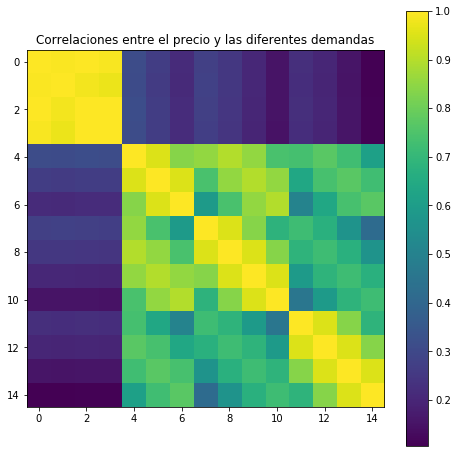

In [94]:
plt.figure(figsize=(8,8))
plt.imshow(data4.corr())
plt.title('Correlaciones entre el precio y las diferentes demandas')
plt.colorbar()
plt.show()

Para interpretar el coeficiente de correlación, tenemos que tener encuenta, que hasta un intervalo de 0'4 - 0'69 no se puede considerar como una correlación positiva moderada. Lo que implica que, de esta matriz de correlaciones no podemos sacar nada en claro, ya que parece que las demandas si que se correlacionan entre sí, como es de esperar, pero más allá de una correlación leve positiva, no podemos extraer ningún dato importante de aquí.

**Conclusiones:**

- Podemos ver como parece que la demanda no tiene ninguna correlación importante con el precio.

### 4.B.- Búsqueda de reglas de asociación:

Para la búsqueda de las reglas de asociación, vamos a utilizar el algoritmo a Priori. Para poder usar este algoritmo, lo primero que necesitamos es que los valores de nuestros datos esten discretizados, por lo que este será el primer paso que haremos. 

Primero empezaremos discretizando los valores de los precios, para ello, empezamos obteniendo todos los precios como una única serie:

In [95]:
serie_precios = convierte_en_serie_horas(precios) # Funcion 9
serie_precios.shape

(26280,)

Vamos a discretizar los precios en 4 valores: bajo, medio-bajo, medio-alto, alto. Para saber como clasificar cada precio, vamos a obtener los cuartiles:

In [96]:
serie_precios.quantile([0.25,0.5,0.75])

0.25    109.31
0.50    116.93
0.75    126.73
dtype: float64

Una vez que tenemos los cuartiles, los utilizamos para discretizar los datos:

In [97]:
precios_sin_descretizar = precios
precios_discretizados = discretiza_precios(precios, [109.31,116.93,126.73]) # Función 10

In [98]:
precios_discretizados

,date,0,1,2,3,4,5,6,7,8,...,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo,cluster
0,2017-01-01,precio alto,precio alto,precio alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,...,precio alto,precio alto,precio alto,precio medio-alto,2017,6,0,1,0,1
1,2017-01-02,precio alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio alto,precio alto,...,precio alto,precio alto,precio alto,precio alto,2017,0,0,0,0,1
2,2017-01-03,precio alto,precio medio-alto,precio medio-alto,precio medio-bajo,precio medio-bajo,precio medio-alto,precio alto,precio alto,precio alto,...,precio alto,precio alto,precio alto,precio alto,2017,1,0,0,0,1
3,2017-01-04,precio alto,precio alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio alto,precio alto,precio alto,...,precio alto,precio alto,precio alto,precio alto,2017,2,0,0,0,1
4,2017-01-05,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-alto,precio medio-bajo,precio medio-bajo,precio medio-alto,precio alto,precio alto,...,precio alto,precio alto,precio alto,precio alto,2017,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,...,precio bajo,precio bajo,precio bajo,precio bajo,2019,4,0,0,0,0
1091,2019-12-28,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,...,precio bajo,precio bajo,precio bajo,precio bajo,2019,5,0,0,0,0
1092,2019-12-29,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,...,precio bajo,precio bajo,precio bajo,precio bajo,2019,6,0,0,0,0
1093,2019-12-30,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,precio bajo,...,precio medio-bajo,precio medio-bajo,precio bajo,precio bajo,2019,0,0,0,0,0


Una vez que tenemos discretizados los precios, repetimos el proceso para discretizar las demandas:

In [99]:
serie_demanda = convierte_en_serie_horas(demanda) # Función 9
serie_demanda.shape

(26280,)

In [100]:
serie_demanda.quantile([0.25,0.5,0.75])

0.25    149696.75
0.50    173941.00
0.75    193886.00
dtype: float64

In [101]:
demandas_discretizadas = discretiza_demanda(demanda, [109.31,116.93,126.73]) # Función 11

In [102]:
demandas_discretizadas.head()

,date,0,1,2,3,4,5,6,7,8,...,20,21,22,23,año,dia_semana,estacion,festivo,pre-festivo,cluster
0,2017-01-01,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,...,demanda alta,demanda alta,demanda alta,demanda alta,2017,6,0,1,0,0
1,2017-01-02,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,...,demanda alta,demanda alta,demanda alta,demanda alta,2017,0,0,0,0,2
2,2017-01-03,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,...,demanda alta,demanda alta,demanda alta,demanda alta,2017,1,0,0,0,1
3,2017-01-04,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,...,demanda alta,demanda alta,demanda alta,demanda alta,2017,2,0,0,0,1
4,2017-01-05,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,demanda alta,...,demanda alta,demanda alta,demanda alta,demanda alta,2017,3,0,0,1,2


Una vez que tenemos nuestros datos discretizados, crearemos un DataFrame, que contenga las columnas a las que queremos aplicarle el algoritmo a Priori

In [103]:
priori = pd.DataFrame()
priori['demanda-1h'] = demanda_retrasada_discretizada(demandas_discretizadas,1) # Función 12
priori['demanda-2h'] = demanda_retrasada_discretizada(demandas_discretizadas,2)
priori['demanda-1s'] = demanda_retrasada_discretizada(demandas_discretizadas,168)
priori['demanda-1s-1h'] = demanda_retrasada_discretizada(demandas_discretizadas,169)
priori['precios'] = convierte_en_serie_horas(precios_discretizados)
priori = priori.loc[170:,:]
priori.head()

,demanda-1h,demanda-2h,demanda-1s,demanda-1s-1h,precios
170,demanda alta-1,demanda alta-2,demanda alta-168,demanda alta-169,precio alto
171,demanda alta-1,demanda alta-2,demanda alta-168,demanda alta-169,precio medio-alto
172,demanda alta-1,demanda alta-2,demanda alta-168,demanda alta-169,precio medio-alto
173,demanda alta-1,demanda alta-2,demanda alta-168,demanda alta-169,precio medio-alto
174,demanda alta-1,demanda alta-2,demanda alta-168,demanda alta-169,precio medio-alto


Una vez que tenemos nuestros datos preparados, convertimos nuestros datos en una lista de listas, en la cual cada una de las listas representará una fila de nuestros datos. Esto lo hacemos porque así lo requiere el algoritmo a Priori:

In [104]:
filas = []
for i in range(1,len(priori)):
    filas.append([str(priori.values[i,j]) for j in range(0,priori.shape[1])])

El algoritmo a Priori nos requerirá de dos parámetros:
- Soporte mínimo: es el ratio de veces en las que en una fila aparece la una palabra, entre el número total de filas.
- Confianza mínima: es el ratio de veces en la que se cumple la regla obtenida.

In [105]:
soporte=0.03
confianza=0.75
apriori(filas, soporte, confianza)# Función 13

Regla: [] -> ['demanda alta-1']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-168']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-169']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-2']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-1', 'demanda alta-168']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-1', 'demanda alta-169']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-1', 'demanda alta-2']
Soporte: 1.0
Confianza: 1.0
Regla: ['precio alto'] -> ['demanda alta-1']
Soporte: 0.2465050365774254
Confianza: 1.0
Regla: ['precio bajo'] -> ['demanda alta-1']
Soporte: 0.251522463518327
Confianza: 1.0
Regla: ['precio medio-alto'] -> ['demanda alta-1']
Soporte: 0.2503734344478915
Confianza: 1.0
Regla: ['precio medio-bajo'] -> ['demanda alta-1']
Soporte: 0.251599065456356
Confianza: 1.0
Regla: [] -> ['demanda alta-169', 'demanda alta-168']
Soporte: 1.0
Confianza: 1.0
Regla: [] -> ['demanda alta-168', 'demanda alta-2']
Soporte: 1.0
Confianza

Como podemos ver el algoritmo a priori obtiene muchas reglas de asociación, pero no nos otorga ninguna en la que el precio sea el consecuente de la implicacion, por lo que no podemos sacar nada en claro del algoritmo a Priori de cara a ayudarnos predecir el precio de la luz.

**Conclusiones:**

- Como hemos visto, ni intentando estudiar correlaciones, ni intentando buscar reglas de asociación, hemos encontrado indicios que muestren una posible relación entre la oferta y la demanda.


- Esto parece revelar que el precio no sigue la ley de la oferta y la demanda, lo que podría deberse a que el mercado de la energía eléctrica es un mercado muy intervenido externamente, tanto por políticas como por intereses empresariales.

## 5.- Predicción de los precios de septiembre de 2019 con horizonte de 24 horas

Para esta quinta parte del estudio, realizaremos una red neuronal que sea capaz de predecir los precios de septiembre de 2019, con un horizonte de 24 horas, con el error mínimo posible.

Para realizar esta predicción usaremos una red neuronal que ya he entrenado previamente en Google Colab, para la cual usaré los datos de los precios de las 42 horas anteriores para hacer la predicción.

### 5.A.- Preparación de los datos:

In [106]:
mirar_atras = 42
precios = pd.read_csv('precios.csv')
precios.head()

,date,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2017-01-01,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,...,120.95,120.15,120.83,127.76,134.42,135.79,137.63,132.23,129.79,121.53
1,2017-01-02,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,...,128.04,127.02,127.31,136.53,140.28,141.97,138.66,134.19,130.78,129.82
2,2017-01-03,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,...,138.93,138.66,138.89,139.75,141.50,142.64,145.28,142.51,142.26,139.56
3,2017-01-04,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,...,137.84,135.87,136.71,141.10,144.29,145.16,145.13,140.49,137.25,134.17
4,2017-01-05,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,...,139.61,139.33,137.68,141.74,142.33,143.88,142.67,142.33,138.63,142.45


Aprovecharemos también para coger el máximo dato y el mínimo del DataFrame, para que cuando hagamos la normalización más adelante, todos los datos esten normalizados con los mismos valores

In [107]:
serie_precios = convierte_en_serie_horas(precios)
maximo = serie_precios.max()
minimo = serie_precios.min()
print('máximo = %.2f, mínimo= %.2f' % (maximo,minimo))

máximo = 239.44, mínimo= 56.35


Como vemos a continuación, a partir del elemento 973 del DataFrame, ya entramos en el mes de septiembre de 2019. Por lo que dividiremos el DataFrame en 2 partes, una para entrenar, y la otra la usaremos como test.

In [108]:
precios.loc[972:973,'date']

972    2019-08-31
973    2019-09-01
Name: date, dtype: object

Como queremos hacer la predicción de los precios de septiembre, y necesitaremos los datos de las horas anteriores establecidas en ``mirar_atras``, tendremos coger datos de agosto para realizar las primeras predicciones de septiembre.

In [109]:
necesarios = dias_para_prediccion(mirar_atras) # Función 14
horas_mes = 30*24
data6 = precios.loc[: 972 - necesarios,'0':'23']
test = precios.loc[973 - necesarios : 973 + 30,'0':'23']
print('Número de datos para test: '+str(test.shape[0]))

Número de datos para test: 33


Ahora procederemos a analizar la serie temporal de los precios de septiembre, para ver cual es nuestro objetivo a predecir.

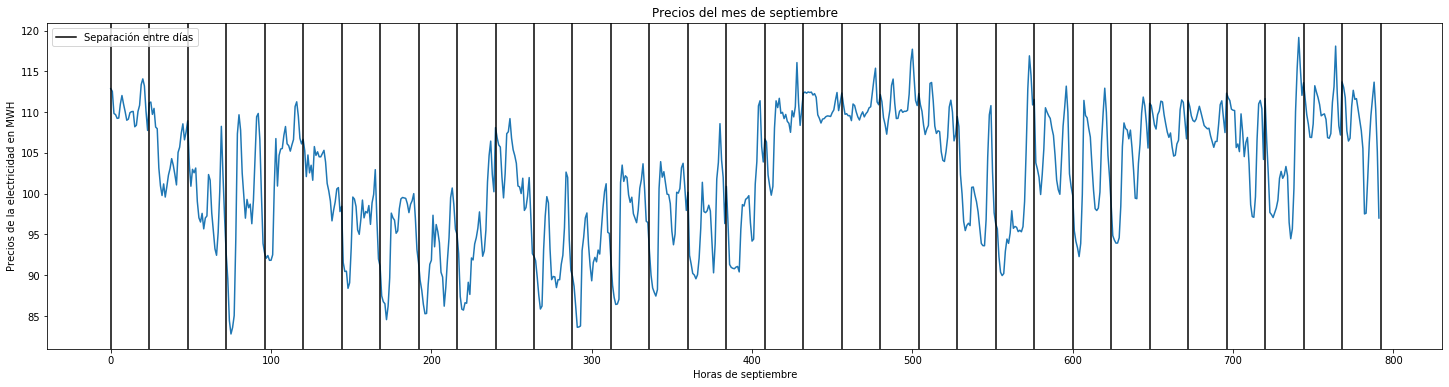

In [110]:
serie_test = test

serie_test = serie_test.reset_index()
del serie_test['index']
serie_test = convierte_en_serie_horas(serie_test)

plt.figure(figsize=(25,6))
plt.title('Precios del mes de septiembre')
plt.xlabel('Horas de septiembre')
plt.ylabel('Precios de la electricidad en MWH')
plt.plot(serie_test)
for i in range(0, len(serie_test)+1, 24):
    if i == 0:
        plt.axvline(x=i, c='black', label = 'Separación entre días')
    else:
        plt.axvline(x=i, c='black')
plt.legend()
plt.show()

Ya que hemos dividido los datos en 2 partes, vamos a realizar una última división en la parte de los datos que vamos a utilizar para entrenar. Esta vez dividiremos los datos de entrenamiento en dos partes: la primera parte que será el 80% de los datos, serán los que usaremos para entrenar la red neuronal, el resto de los datos los usaremos como método de validación para comprobar que efectivamente la red neuronal está entrenando correctamente.

In [111]:
size = int(len(data6)*0.8)
train = data6[:size]
validation = data6[size+1:]
print('Número de datos para entrenamiento: ' + str(train.shape[0])+
      '\nNúmero de datos para validación: '+str(validation.shape[0]))

Número de datos para entrenamiento: 776
Número de datos para validación: 194


Ahora procederemos a normalizar los valores de los precios de los datos de; entrenamiento, validación y test, sobre los mismo valores, de forma que todos los valores se normalicen con la misma proporción:

In [112]:
train_norm = (train-minimo)/(maximo-minimo) 
validation_norm = (validation-minimo)/(maximo-minimo)
test_norm = (test-minimo)/(maximo-minimo)

Por último, prepararemos los datos para ser entendidos por la red neuronal: 

In [113]:
X_train, y_train = crea_base_datos(train_norm, mirar_atras) #Función 15

Días necesarios = 2 
Hora a partir de la que se cogen datos del último día = 6 
Tamaño X = (773, 1, 42) 
Tamaño de y = (773, 24)


In [114]:
X_validation, y_validation = crea_base_datos(validation_norm, mirar_atras)

Días necesarios = 2 
Hora a partir de la que se cogen datos del último día = 6 
Tamaño X = (191, 1, 42) 
Tamaño de y = (191, 24)


In [115]:
X_test, y_test = crea_base_datos(test_norm, mirar_atras)

Días necesarios = 2 
Hora a partir de la que se cogen datos del último día = 6 
Tamaño X = (30, 1, 42) 
Tamaño de y = (30, 24)


### 5.B.- Definición y entrenamiento de la red neuronal:

Para realizar la predicción, haremos uso de una red recurrente (RNN) compuesta de capas Long Short-Term Memory (LSTM) y capas de Perceptrones.

Las capas LSTM tienen 4 tipos de puertas diferentes:
- La puerta de olvido, es la encargada de establecer qué información deja de ser relavante.
- La puerta de de entrada, es la encargada de decidir qué información del momento actual es más importante.
- La puerta de salida, encargada de decidir qué información del pasado es más relevante.
- El estado de celda, la cual es representada por, la más alta de las dos líneas que pasan entre las neuronas.


<img src='https://t1.daumcdn.net/cfile/tistory/22023B4F592AE8B617'>

In [116]:
import tensorflow
import tensorflow.keras as keras
import keras.backend as K
from keras.layers import LSTM, Dense, Input
from keras.models import Model

input = Input(shape=(1,mirar_atras))
x = LSTM(22)(input)
x = Dense(24, activation='linear')(x)
model = Model(inputs=input, outputs=x)
model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 42)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 22)                5720      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                552       
Total params: 6,272
Trainable params: 6,272
Non-trainable params: 0
_________________________________________________________________


- La primera capa (InputLayer) es la recibe los datos de entrada. 
- La segunda, es la capa de LSTM, es la que le aportará la recurrencia al modelo.
- La última capa es la de Perceptrones, esta capa tiene 24 neuronas, las cuáles nos darán los resultados de los precios de la electricidad en las próximas 24 horas.


Para hacer diminuir la carga de la ejecución de este notebook, el entrenamiento del modelo ya se ha realizado en previamente en Google Colab, por lo que ahora mismo nos limitaremos a cargar los pesos del modelo. Áun así, aquí expondré el código utilizado para entrenar la red.

Como callbacks he utilizado ModelCheckpoint, para guardar los mejores pesos obtenidos durante el entrenamiento del modelo:

```from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/gdrive/My Drive/Colab Notebooks/datos_electricidad/autoguardado.h5', monitor='val_los', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)```

Como función de pérdidas he usado el error absoluto medio (MAE), el cual se calcula de la siguiente fórmula:

\begin{align}
MAE = \frac{1}{n}\sum_{i=1}^n{ |y_i - \gamma_i|}
                                                           \quad \quad \text{$y_{i}$ = valor real de elemento i}\\
                                                           \quad \quad \text{$\gamma_{i}$ = predicción del elemento i}\\
\end{align}



Además, como optimizador he usado Adam, he escogido este, porque este optimizador puede ir modificando el ratio de entrenamiento durante el entrenamiento del modelo:

```model.compile(loss='mae', optimizer='adam')```

El tamaño de batch escogido es 8, ya que proprocionará una estimación de gradiente más ruidoso, lo que ayudará a que el algoritmo consiga salir de los óptimos locales.

Para entrenar he ejecutado el siguiente código:

```history = model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, validation_data=(X_validation, y_validation))
```

La gráfica de la función de entrenamiento obtenida es la siguiente:
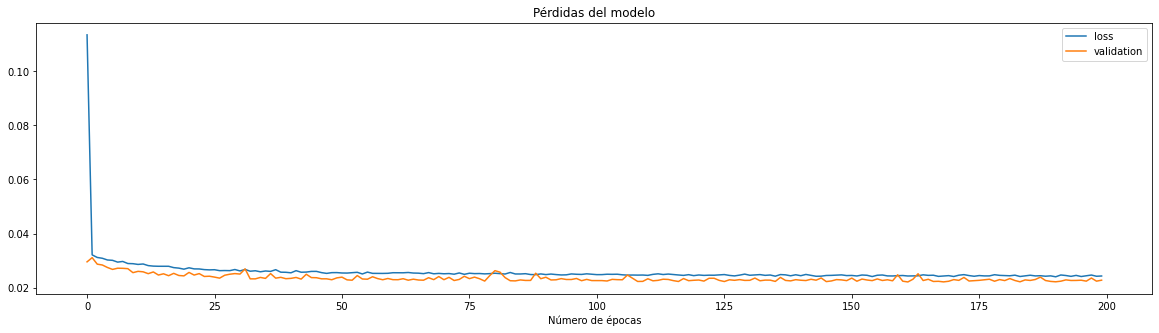

Ahora que hemos explicado el proceso de entrenamiento realizado, vamos a cargar los pesos obtenidos:

In [125]:
model.load_weights('autoguardado.h5')

### 5.C.- Predicción y evaluación de la red neuronal:

Una vez que tenemos la red neuronal entrenada, procedemos a realizar una predicción:

In [126]:
y_pred = model.predict(X_test)
len(y_pred)

30

Antes de nada, para poder hacer el cálculo del error, des-normalizaremos y serializaremos los datos de y_test e y_pred, para poder ver una serie con sus valores originales:

In [127]:
y_pred_desnorm = y_pred*(maximo-minimo) + minimo
y_test_desnorm = y_test*(maximo-minimo) + minimo

y_pred_desnorm = serializa_lista_distintos_tam(y_pred_desnorm)
y_test_desnorm = serializa_lista_distintos_tam(y_test_desnorm)

Para el cálculo del error, además del MAE, usaremos otras dos medidas:

La primera es el error medio cuadrático (MSE), el cúal penalizará los errores grandes, y que tiene la siguiente fórmula:

\begin{align}
MSE = \frac{1}{n}\sum_{i=1}^n{ (y_i - \gamma_i)^2}
                                                           \quad \quad \text{$y_{i}$ = valor real de elemento i}\\
                                                           \quad \quad \text{$\gamma_{i}$ = predicción del elemento i}\\
\end{align}

La segunda de las nuevas medidas, es la raíz del error medio cuadrático (RMSE), la cúal es como el MSE, pero permitiendo interpretar el valor del error en las mismas unidades que RMSE. El RMSE tiene la siguiente fórmula:

\begin{align}
MSE = \sqrt{\frac{1}{n}\sum_{i=1}^n{ (y_i - \gamma_i)^2}}
                                                           \quad \quad \text{$y_{i}$ = valor real de elemento i}\\
                                                           \quad \quad \text{$\gamma_{i}$ = predicción del elemento i}\\
\end{align}

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_pred_desnorm, y_test_desnorm)
mse = mean_squared_error(y_pred_desnorm, y_test_desnorm)
rmse = math.sqrt(mean_squared_error(y_pred_desnorm, y_test_desnorm))
print('''MAE = %.2f
MSE = %.2f
RMSE = %.2f ''' % (mae,mse,rmse))

MAE = 3.78
MSE = 23.68
RMSE = 4.87 


Por último, visualizaremos la serie temporal real del precio durante el mes de septiembre, junto a la serie temporal predecida por el modelo:

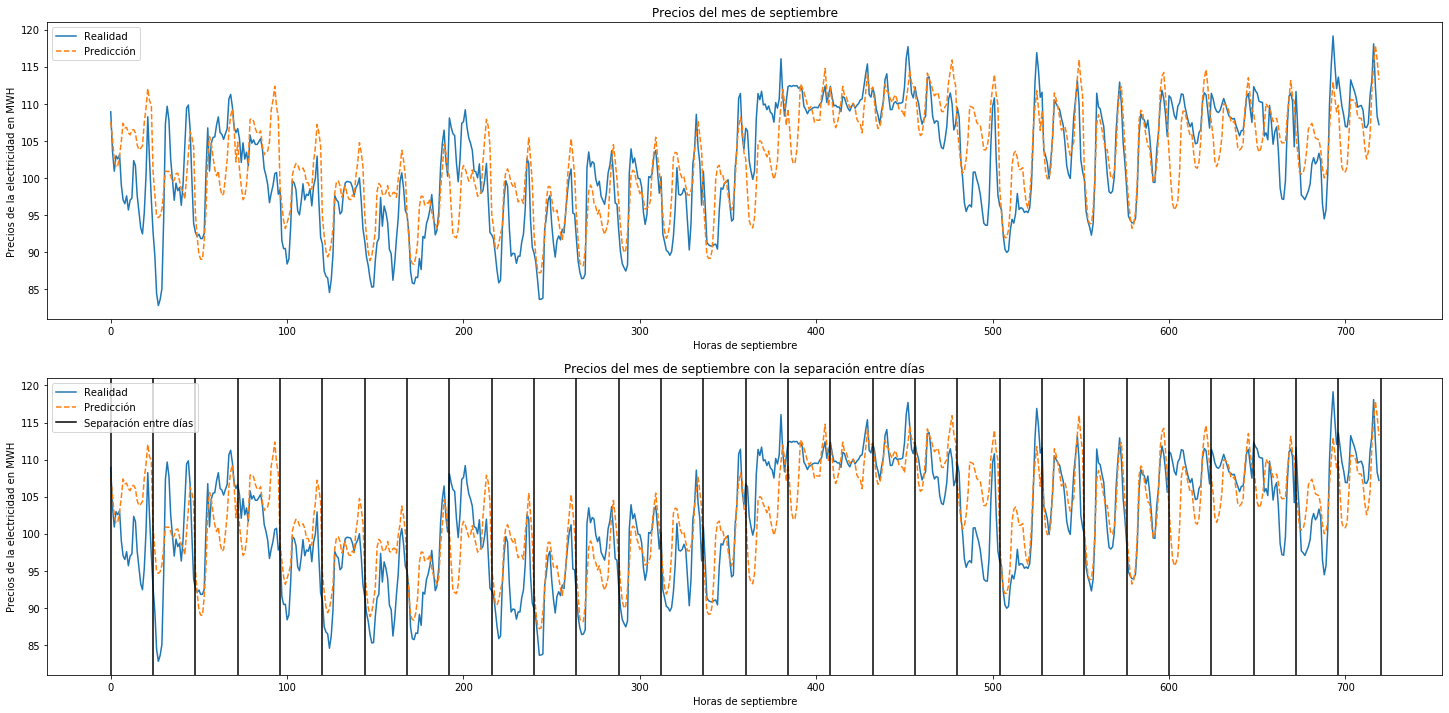

In [121]:
fig,(axis1,axis2)=plt.subplots(2,1)
fig.set_size_inches(25,12)

#Gráfica 1
axis1.set_title('Precios del mes de septiembre')
axis1.set_xlabel('Horas de septiembre')
axis1.set_ylabel('Precios de la electricidad en MWH')
axis1.plot(y_test_desnorm, label='Realidad')
axis1.plot(y_pred_desnorm, label='Predicción', linestyle='dashed')
axis1.legend()

#Gráfica 2
axis2.set_title('Precios del mes de septiembre con la separación entre días')
axis2.set_xlabel('Horas de septiembre')
axis2.set_ylabel('Precios de la electricidad en MWH')
axis2.plot(y_test_desnorm, label='Realidad')
axis2.plot(y_pred_desnorm, label='Predicción', linestyle='dashed')

#Líneas que marcan las separaciones entre los días
for i in range(0, len(y_pred_desnorm)+1, 24):
    if i == 0:
        axis2.axvline(x=i, c='black', label = 'Separación entre días')
    else:
        axis2.axvline(x=i, c='black')
axis2.legend()


plt.show()

## 6.- Conclusiones:

En este estudio de la electricidad hemos analizado muchos aspectos de la misma, y gracias a ello hemos obtenido varias conclusiones interesantes, que en este apartado nos dedicaremos a recopilar de forma clara y resumida.


**Tipos de clusters de la demanda:**

En cuanto a los clusters de los tipos de los días de la demanda, hemos averiguado que se dividen en 3 clusters diferentes:

- Cluster 0: Días con poca demanda, como: fin de semanas, días festivos y algunos días previos a festivos.


- Cluster 1: Días de mucha demanda, como: días de verano e invierno, y los martes, miércoles y jueves.


- Cluster 2: Días de demanda media, como: días de primavera y otoño, los lunes y viernes y algunos días previos a festivos.


**Tipos de clusters del precio:**

En cuanto a los clusters de los tipos de días según el precio, sabemos que también se dividen en 3:

- Cluster 0: Días con precio bajo, como: los días de 2019, y los días del año con menos precio como suelen ser los días de primavera, festivos y previos a festivos. 


- Cluster 1: Días con precio alto, como: los días de 2018, los días de invierno y días de otoño.


- Cluster 2: Días con un precio medio, como: los días de 2017, que fué el año en el que el precio se mantuvo en un valor medio comparado con los valores de los otros años.



**Relacionar ambas series temporales:**

Por desgracia en este estudio no hemos conseguido encontrar una relación importante entre las dos series, esto podría deberse a dos motivos:

 1. La intervención de las políticas y las empresas en el precio de la luz, lo que provoca que el precio no este relacionado con la demanda al no seguir la ley de la oferta y la demanda.
 
 
 2. Una mala aplicación de los algoritmos usados, una necesidad de aplicar otros más potentes o que nos puedan ayudar en otros aspectos o una necesidad de haber abordado esta investigación desde un ángulo diferente.
 
 
**Predicción de los precios de septiembre de 2019 con horizonte de 24 horas:**

Para este apartado, hemos conseguido un éxito relativo; si bien hemos conseguido predecir los precios con un error medio absoluto de 3.78€, soy consciente de que el modelo utilizado es bastante simple.

Según estoy estudiando en la asignatura de Inteligencia Artificial de la universidad, la mayoría de las veces, una sola capa oculta con pocas unidades basta para obtener buenos resultados. Aún así, yo personalmente pienso que posiblemente habiendo implementado un modelo más complejo y puntero, probablemente se podrían haber obtenido mejores resultados. 

## 7.- Posibles mejoras:

Para este proyecto he tenido que realizar un amplio proceso de investigación, porque a pesar de tener algo de experiencia con Python y librerias como Pandas y Scikit-Learn, no tenía ningún conocimiento sobre aprendizaje no supervisado, ni sobre algoritmos para encontrar reglas de asociación. Además, aunque había empezado un curso en Udemy sobre redes neuronales, ni lo había terminado ni nunca había llegado a contruir una red neuronal.

Este proceso de investigación, me ha llevado a completar un curso de de Udemy sobre redes neuronales, completar el tema de aprendizaje no supervisado de otro curso de Udemy, investigar por internet llegando a páginas como Papers with Code o haciéndome entrar por primera vez en foros sobre Machine Learning en busca de respuestas.

Todo esto me hace consciente de que este proyecto se puede mejorar, y en este apartado quiero dejar plasmadas propuestas de mejoras:

**En cuanto a la Red Neuronal:**

A través del foro de de Machine Learning Hispano conocí la página Papers with Code, donde pude informarme sobre el estado del arte de la predicción de series temporales.

Gracias a esto, puedo determinar que mi propuesta de mejora, sería implementar un modelo más potente para la predicción de series temporales como es el *Dual-Stage Attention-Based Recurrent Neural Network*, y después de esto hacerle Fine Tunnning para adaptarla al problema que estamos tratando.

Aunque en un principio he intentado adaptar modelos como este o como el de *Prophet (fbprophet)*, al no tener experiencia no he sido capaz de construir los modelos para poder implementarlos.

También, podríamos haber intentado tener en cuenta las propiedades de los días, estudiadas en la parte de la búsqueda de clusters, para intentar hacer predicciones más acertadas.

**En cuanto a la búsqueda de reglas de asociación:**

En esta aparte, se podría haber aplicado un algoritmo mejor que el Apriori, puesto que al tener que hacer el refinamiento posterior a mano, pienso que posiblemente se podría haber obtenido un mejor resultado con otro. Probablemente podríamos haber utilizado el software de Keel para esta parte, pero por desgracia al no haber podido de comprender del todo el funcionamiento de este software, no he podido aplicarlo para este proyecto.

En esta parte, igual que la anterior, creo que se podría haber tenido en cuenta las propiedades de los días, estudiadas anteriormente, para intentar buscar mejores relaciones.


**En cuanto a la búsqueda del número de clusters:**

Esta es la parte del proyecto en la que tengo menos propuestas de mejora.

Respecto a los algoritmos, además de los expuestos en el proyecto, he probado con otros como el de los K-Medoides, el clustering spectral e incluso he intentado encontrar el número óptimo de clusters gracias al algoritmo de la propagación de la afinidad, pero finalmente los he tenido que ir descartando, porque, o no convergían para este problema, o no me daban unos resultados que me convencieran o aportaran algo más al estudio.

Por otra parte, para los datos, sólo se me ocurre haber tenido en cuenta más variables externas para ver si influían en el resultado, pero por lo general, estoy satisfecho con esta parte.

## 8.- Bibliografía:

En esta parte, citaremos todas las fuentes utilizadas para adquirir los conocimientos utilizados en la realización de este estudio.

**Tratamiento de datos con la librería pandas:**

- Markham, K. (2016). Easier data analysis in Python with pandas (video series). Retrieved 3 March 2020, from https://www.dataschool.io/easier-data-analysis-with-pandas/

**Manejo de la libreria de Scikit-Learn:**

- Markham, K. (2016). Introduction to machine learning in Python with scikit-learn (video series). Retrieved 10 March 2020, from https://www.dataschool.io/machine-learning-with-scikit-learn/

**Aprendizaje no supervisado:**

- Gomilas Salas, J. Curso completo de Machine Learning: Data Science en Python. Retrieved 31 March 2020, from https://www.udemy.com/course/machinelearningpython/

**Redes neuronales:**

- Fuentes Jiménez, D. Deep Learning e Inteligencia artificial con Keras/Tensorflow. Retrieved 12 April 2020, from https://www.udemy.com/course/curso-de-deep-learning-con-kerastensorflow-en-python/


- Qin, Y., Song, D., Chen, H., Cheng, W., Jiang, G., & Cottrell, G. (2017). A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction. Retrieved 20 April 2020, from https://arxiv.org/abs/1704.02971


- Gupta, R. (2019). The Fastest and Easiest Way to Forecast Data on Python. Retrieved 20 April 2020, from https://towardsdatascience.com/the-fastest-and-easiest-way-to-forecast-data-on-python-d7ff29f3add6


- Chen, J., Zhou, D., Tang, Y., Yang, Z., & Gu, Q. (2018). Closing the Generalization Gap of Adaptive Gradient Methods in Training Deep Neural Networks. Retrieved 24 April 2020, from https://arxiv.org/abs/1806.06763


- Hincapie Potes, S. (2020). El arcano arte de entrenar redes neuronales. Retrieved 23 April 2020, from https://www.youtube.com/watch?v=p2xloyBT5C8&list=LLUVjIuSsVOBNi5_wQV1oAzg&index=3&t=0s

**Algoritmo Apriori:**

- Data Science Apriori Algorithm in Python- Market Basket Analysis - Intellipaat. (2019). Retrieved 13 April 2020, from https://intellipaat.com/blog/data-science-apriori-algorithm/


- Russi, D. (2020). Algoritmo Apriori - UFSM. Retrieved 13 April 2020, from https://www.youtube.com/watch?v=suwzIKi27Ao

**Interpretación de coeficiente de correlación de Person**

- Suárez Ibujes, M. (2020). Coeficiente de correlación de Karl Pearson - Monografias.com. Retrieved 1 May 2020, from https://www.monografias.com/trabajos85/coeficiente-correlacion-karl-pearson/coeficiente-correlacion-karl-pearson.shtml